In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
np.float = float
np.bool = bool
np.int = int
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import time
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import utils
import shap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df_meta = pd.read_csv("immusign/data/lymphoma-reps-file-infos.csv")
lymphoma_types = df_meta["lymphoma_specification"].unique()

In [3]:
df_meta.columns

Index(['pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'clones.txt.name', 'subject_id', 'sex',
       'dosc', 'age', 'dob'],
      dtype='object')

In [4]:
lymphoma_types

array(['cll', 'hd', 'unspecified', 'abc_dlbcl', 'nlphl', 'thrlbcl',
       'dlbcl', 'lymphadenitis', 'gcb_dlbcl'], dtype=object)

In [5]:
df_raw = utils.read_clones_txt(df_meta["clones.txt.name"].values, "immusign/data/clones_mit_kidera")
df_raw["cloneFraction"] = df_raw["cloneFraction"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if isinstance(x, str) else float(x))

  0%|          | 0/1394 [00:00<?, ?it/s]

In [51]:
df_raw.columns

Index(['cloneId', 'cloneCount', 'cloneFraction', 'nSeqCDR3', 'aaSeqCDR3',
       'bestVGene', 'bestDGene', 'bestJGene', 'vBestIdentityPercent',
       'lengthOfCDR3', 'targetSequences', 'allVGenes', 'allDGenes',
       'allJGenes', 'allVHits', 'allDHits', 'allJHits', 'allVAlignments',
       'allDAlignments', 'allJAlignments', 'KF1', 'KF2', 'KF3', 'KF4', 'KF5',
       'KF6', 'KF7', 'KF8', 'KF9', 'KF10', 'clones.txt.name',
       'dBestIdentityPercent', 'jBestIdentityPercent', 'aaSeqCDR2',
       'aaSeqCDR1', 'aaSeqFR2', 'aaSeqFR3', 'aaSeqFR4',
       'aaSeqImputedVDJRegion'],
      dtype='object')

# Load Data read from R-Script

In [6]:
import rpy2.robjects as robjects
robjects.r['load']("immusign/immusign_not_normalized_with_out_of_frame.RData")
twb = robjects.r['twb']

In [19]:
df = utils.convert_rtwb_to_pdtwb(twb)

In [20]:
df["clones.txt.name"] = df["sample"].apply(lambda x: x + ".clones.txt")

In [21]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name'],
      dtype='object')

In [22]:
len(df)

3015432

# Add metric info

In [23]:
stats = pd.read_csv("immusign/output/stats.csv", sep=";")
stats.rename(columns={stats.columns[0]:"sample"}, inplace=True)

In [24]:
df = df.merge(stats.iloc[:-2], on = "sample")

In [25]:
len(df)

3015432

# Add meta info

In [26]:
df = df.merge(df_meta, on = "clones.txt.name")

In [28]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob'],
      dtype='object')

In [27]:
len(df)

3015432

# Add correct clone Id before adding info from raw files

In [29]:
df["cloneId"] = None

for file in tqdm(df["clones.txt.name"].unique()):
    df_sub_file = df[df["clones.txt.name"] == file]
    df_raw_sub_file = df_raw[df_raw["clones.txt.name"] == file]
    for i, index_row in enumerate(df_sub_file.iterrows()):
        index, row = index_row[0], index_row[1]  
        if row["CDR3.nucleotide.sequence"] == df_raw_sub_file.iloc[i]["nSeqCDR3"]:
            df.loc[index,"cloneId"] = df_raw_sub_file.iloc[i]["cloneId"]

  0%|          | 0/1394 [00:00<?, ?it/s]

In [30]:
df2 = df.merge(df_raw, left_on=["clones.txt.name", "cloneId", "CDR3.nucleotide.sequence"], right_on =["clones.txt.name", "cloneId", "nSeqCDR3"], how = "left")

In [31]:
df2.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBes

In [122]:
#df2.to_pickle("immusign_40000_reads_with_mutations_merged_raw_data.pkl")

In [91]:
#df.to_pickle("immusign_40000_reads_with_mutations_merged_raw_data_cleaned.pkl")

# Get rid of redundant information

In [76]:
#df = pd.read_pickle("immusign_40000_reads_with_out_of_frame_merged_raw_data.pkl")

### CDR3.amino.acid.sequence from R-scripts and aaSeqCDR3 from files not the same

In [ ]:
# test = df[~(df["CDR3.amino.acid.sequence"].apply(lambda x: x.replace("~", "_")) == df["aaSeqCDR3"])]

In [57]:
print(df["CDR3.amino.acid.sequence"].apply(lambda x: x.replace("~", "_")).loc[7])
print(df["aaSeqCDR3"].loc[7])

CASKSND_TGKGYW
CASKSN_TGKGYW


### bunch.translate function either drops 2 nucleotide (seq_len % 3 = 2) or repeats 2 nucleotides (seq_len % 2 = 1) leading to additional AS e.g. D in example above

In [77]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBes

In [33]:
df2.drop(columns = ['Umi.count', 'Umi.proportion', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'nSeqCDR3'],inplace=True)

In [4]:
df["aaSeqCDR3"].unique()

array(['CARSPDHW', 'CARDVVVGYYYGMDVW', 'CASGYFEYSSSRPYGMDVW', ...,
       'CARAARQGSTGYYFFDYW', 'CARDLGRFSPPFCSGINCYEGGGFDPW',
       'CAREQEPYSNTDFW'], dtype=object)

In [34]:
df2["Clonality"] = df["Clonality"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))
df2["twb.shannon"] = df["twb.shannon"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))
df2["twb.simp"] = df["twb.simp"].apply(lambda x: float(x.replace(",",".").replace("+","-")) if type(x) == str else float(x))

In [35]:
df2["age"] = df["age"].apply(lambda x: utils.tryconvert(x, np.nan, float))

In [38]:
np.sum(df2["age"].isnull())

445672

In [39]:
np.sum(df2["sex"].isnull())

390258

In [40]:
unkown_sex_id = df2[df2["sex"].isnull()]["subject_id"].unique()

In [46]:
found_sex_in_other_rows = df2[df2.subject_id.isin(unkown_sex_id)][~df2[df2.subject_id.isin(unkown_sex_id)]["sex"].isnull()][["sex", "subject_id"]].groupby(["sex", "subject_id"]).first().reset_index()
found_sex_in_other_rows

,sex,subject_id
0,female,CLL394
1,female,DLBCL15
2,female,HD020
3,female,HD021
4,female,HD037
5,female,HD086
6,female,HD092
7,female,HD094
8,female,HD095
9,female,HD096


In [47]:
for i, row in found_sex_in_other_rows.iterrows():
    id = row.subject_id
    sex = row.sex
    df2.loc[df2.subject_id == id,"sex"] = sex

In [49]:
np.sum(df2["sex"].isnull())

365760

In [50]:
unkown_age_id = df2[df2["age"].isnull()]["subject_id"].unique()

In [52]:
found_age_in_other_rows = df2[df2.subject_id.isin(unkown_age_id)][~df2[df2.subject_id.isin(unkown_age_id)]["age"].isnull()][["age", "subject_id"]].groupby(["age", "subject_id"]).first().reset_index()
found_age_in_other_rows

,age,subject_id
0,22.0,HD018
1,23.0,HD015
2,23.0,HD016
3,23.0,HD095
4,26.0,HD086
5,26.0,HD097
6,27.0,HD009
7,27.0,HD079
8,27.0,HD086
9,28.0,HD032


In [65]:
df2.loc[df.subject_id == "CLL368",["age", ]].unique()

array([63., 64., nan])

In [61]:
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/labadmin/Projects/immusign/utils.py'>

In [62]:
for idx, row in df2[df2["age"].isnull()].iterrows():
    if (not pd.isnull(row.dob)) and (not pd.isnull(row.dosc)):
        df2.loc[idx, "age"] = utils.from_dosc_and_dob_to_age(row.dob, row.dosc)

In [63]:
unkown_age_id = df2[df2["age"].isnull()]["subject_id"].unique()

In [65]:
found_age_in_other_rows = df2[df2.subject_id.isin(unkown_age_id)][~df2[df2.subject_id.isin(unkown_age_id)]["age"].isnull()][["age", "subject_id"]].groupby(["age", "subject_id"]).first().reset_index()
found_age_in_other_rows

,age,subject_id
0,22.0,HD018
1,23.0,HD015
2,23.0,HD016
3,23.0,HD095
4,26.0,HD086
5,26.0,HD097
6,27.0,HD009
7,27.0,HD079
8,27.0,HD086
9,28.0,HD032


In [70]:
subjects, counts = np.unique(found_age_in_other_rows.subject_id, return_counts = True)

In [76]:
doubles = subjects[counts>=2]
doubles

array(['CLL144', 'HD009', 'HD037', 'HD079', 'HD086'], dtype=object)

In [79]:
for i, row in found_age_in_other_rows.iterrows():
    id = row.subject_id
    age = row.age
    if not (id in doubles):
        df2.loc[df2.subject_id == id,"age"] = age

In [80]:
df.loc[(df.subject_id == "CLL144") & (df.age.isnull()),"age"] = 65
df.loc[(df.subject_id == "HD037") & (df.age.isnull()),"age"] = 37
df.loc[(df.subject_id == "HD009") & (df.age.isnull()),"age"] = 31
df.loc[(df.subject_id == "HD079") & (df.age.isnull()),"age"] = 30
df.loc[(df.subject_id == "HD086") & (df.age.isnull()),"age"] = 26

In [82]:
np.sum(df2["age"].isnull())

384399

In [83]:
df2["has_mutation"] = df2["aaSeqCDR3"].apply(lambda x: "_" in x or "*" in x)

In [84]:
#df2.to_pickle("immusign/immusign_not_normalized_with_out_of_frame_merged_raw_data_cleaned.pkl")

# Small Analysis

In [85]:
df = pd.read_pickle("immusign/immusign_not_normalized_with_out_of_frame_merged_raw_data_cleaned.pkl")

In [86]:
df.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

## Columns
cloneId --> Identified clones per sample <br>
cloneCount --> Absolute number found in sample <br>
cloneFraction --> Relative number found in sample (Attention: smaller than cloneCount/sum(cloneCount) because cut off < 2<br>
nSeqCDR3 --> Nucleotid sequence <br>
aaSeqCDR3 --> Amino Acid Sequence <br>
bestVGene --> best matching VGene <br>
bestDGene --> best matching DGene <br>
bestJGene --> best matching JGene <br>
vBestIdentityPercent --> Certainty of best matching VGene <br>
lengthOfCDR3 --> length of nucleotid sequence <br>
targetSequences --> Full sequence of nSeqCDR3 <br>
allVGenes --> All possible matches of V genes<br>
allDGenes --> All possible matches of D genes <br>
allJGenes --> All possible matches of J genes <br>
allVHits --> All V hits <br>
allDHits --> All D hits <br>
allJHits --> All J hits <br>
allVAlignments --> Alignments for each V hit <br>
allDAlignments --> Alignments for each D hit <br>
allJAlignments --> Alignments for each J hit <br>
KF1 - KF10 --> Kidera Factors <br>
clones.txt.name --> Sample file <br>
dBestIdentityPercent  --> Certainty of best matching DGene  <br>
jBestIdentityPercent  --> Certainty of best matching JGene  <br>
aaSeqCDR2 --> Amino Acid Sequence <br>
aaSeqCDR1 --> Amino Acid Sequence <br>
aaSeqFR2 --> Amino Acid Sequence  <br>
aaSeqFR3 --> Amino Acid Sequence  <br>
aaSeqFR4 --> Amino Acid Sequence <br>
aaSeqImputedVDJRegion --> Amino Acid Sequence <br>
<br>
--- META DATA ---<br>
pcr_target_locus --> Target Region of PCR ('IGH', 'TRB', 'IGHFR3', 'IGHFR2', 'TRBFR3') <br>
organism --> Organism of sample (hs) <br>
template --> DNA <br>
tissue --> Blood or Tissue['pb', 'tm'] <br>
lymphoma_type --> Identified lymphoma type <br>
lymphoma_specification --> dentified lymphoma type <br>
subject_id <br>
sex <br>
dosc --> date of sample collection <br>
age <br>
dob -->  date of birth<br>


# Distribution of data

<Axes: xlabel='lymphoma_specification', ylabel='Count'>

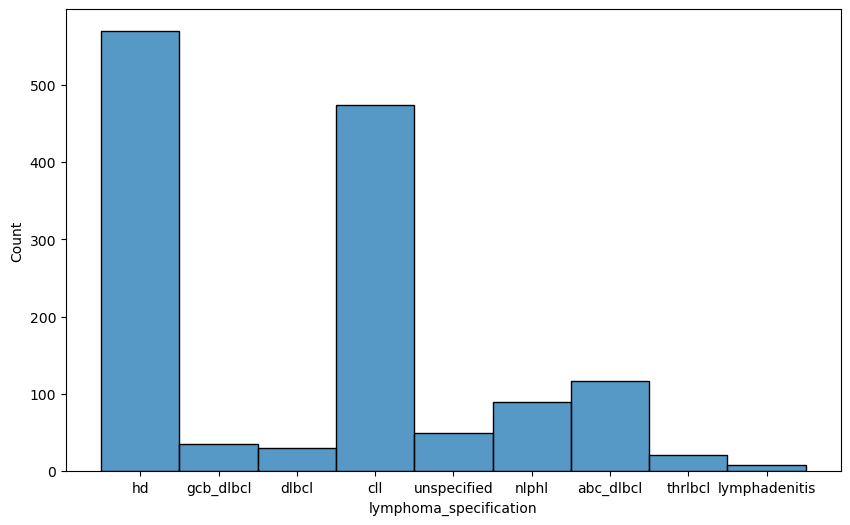

In [87]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df.groupby("clones.txt.name").first().reset_index()["lymphoma_specification"],ax = ax)

In [10]:
df.columns

Index(['Umi.count', 'Umi.proportion', 'Read.count', 'Read.proportion',
       'CDR3.nucleotide.sequence', 'CDR3.amino.acid.sequence', 'V.gene',
       'J.gene', 'D.gene', 'V.end', 'J.start', 'D5.end', 'D3.end',
       'VD.insertions', 'DJ.insertions', 'Total.insertions', 'sample',
       'cloneId', 'clones.txt.name', '#Nucleotide clones',
       '#Aminoacid clonotypes', '%Aminoacid clonotypes', '#In-frames',
       '%In-frames', '#Out-of-frames', '%Out-of-frames', 'Sum.reads',
       'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Sum.UMIs', 'Min.UMIs', '1st Qu.UMIs',
       'Median.UMIs', 'Mean.UMIs', '3rd Qu.UMIs', 'Max.UMIs', 'Clonality',
       'twb.shannon', 'twb.simp', 'pcr_target_locus', 'organism', 'template',
       'tissue', 'lymphoma_type', 'lymphoma_specification', 'subject_id',
       'sex', 'dosc', 'age', 'dob', 'cloneCount', 'cloneFraction', 'nSeqCDR3',
       'aaSeqCDR3', 'bestVGene', 'bestDGene', 'bestJGene',
       'vBes

# Mutations in Data

In [88]:
df_mutations = df[df["aaSeqCDR3"].apply(lambda x: "_" in x or "*" in x)]
mutations_per_group = df_mutations.groupby("lymphoma_specification").apply(len).reset_index()
total_per_group = df.groupby("lymphoma_specification").apply(len).reset_index()

In [89]:
total_per_group

,lymphoma_specification,0
0,abc_dlbcl,27046
1,cll,213940
2,dlbcl,27678
3,gcb_dlbcl,7009
4,hd,2106847
5,lymphadenitis,100105
6,nlphl,436737
7,thrlbcl,40408
8,unspecified,55662


In [90]:
mutations_per_group

,lymphoma_specification,0
0,abc_dlbcl,3096
1,cll,33248
2,dlbcl,3715
3,gcb_dlbcl,896
4,hd,324873
5,lymphadenitis,11928
6,nlphl,54006
7,thrlbcl,4436
8,unspecified,7825


In [91]:
mutations_per_group[0]/total_per_group[0]

0    0.114472
1    0.155408
2    0.134222
3    0.127836
4    0.154199
5    0.119155
6    0.123658
7    0.109780
8    0.140581
Name: 0, dtype: float64

## % Mutations per Group

Text(0, 0.5, 'non-productive AA (%)')

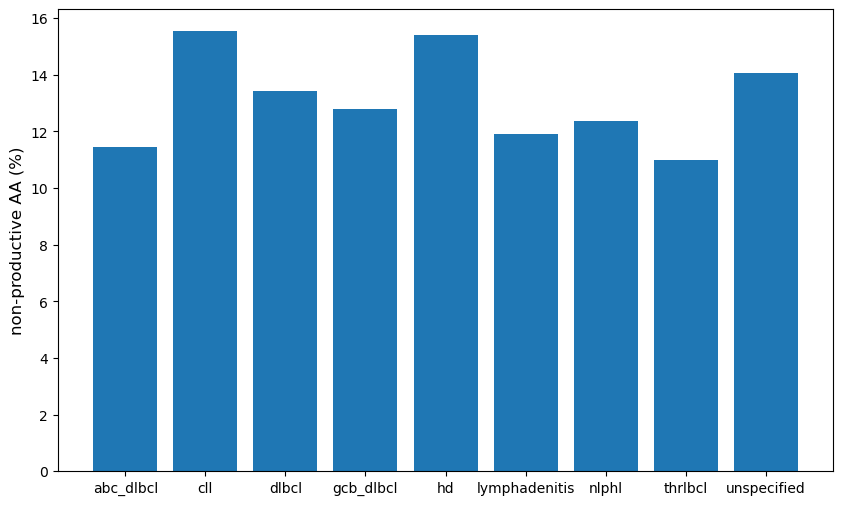

In [92]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(mutations_per_group["lymphoma_specification"],mutations_per_group[0]/total_per_group[0] * 100)
ax.set_ylabel("non-productive AA (%)", size=12)

In [93]:
mutations_per_patient = df_mutations.groupby("clones.txt.name").apply(len).reset_index()
total_per_patient = df.groupby("clones.txt.name").apply(len).reset_index()

In [94]:
mutations_per_patient = mutations_per_patient.merge(total_per_patient, on="clones.txt.name",how="left")

In [95]:
mutations_per_patient = mutations_per_patient.merge(df_mutations[["clones.txt.name","lymphoma_specification"]], on="clones.txt.name", how="left")

In [96]:
mutations_per_patient["non-productive AA (%)"] = mutations_per_patient["0_x"]/mutations_per_patient["0_y"] * 100

In [97]:
mutations_per_patient.sort_values(by="lymphoma_specification", inplace = True)

## % Mutations per patient in groups

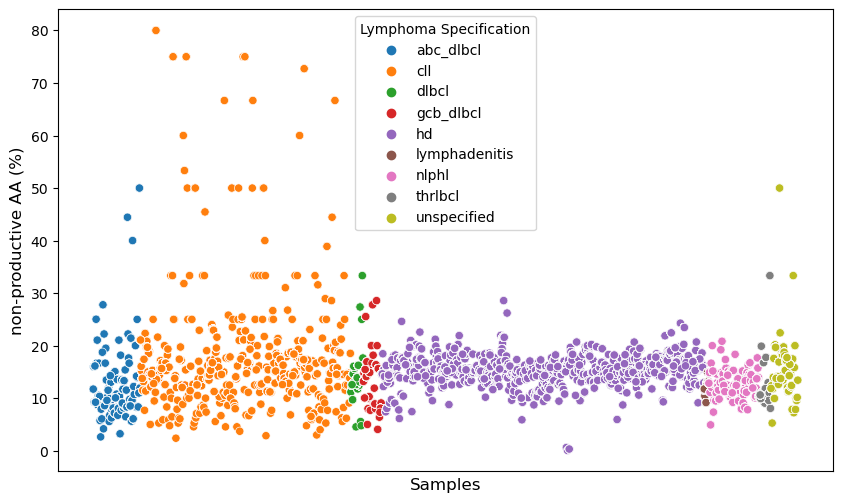

In [98]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='clones.txt.name', y='non-productive AA (%)', hue='lymphoma_specification', data=mutations_per_patient) 
ax.set_xticks([])
ax.set_ylabel("non-productive AA (%)", size=12)
ax.set_xlabel("Samples", size=12)
ax.legend(title='Lymphoma Specification')
plt.show()

In [99]:
df[df["lymphoma_specification"] == "dlbcl"].age.isnull()

869923     True
869924     True
869925     True
869926     True
869927     True
           ... 
2741489    True
2741490    True
2741491    True
2741492    True
2741493    True
Name: age, Length: 27678, dtype: bool

In [374]:
df_age = df.groupby("clones.txt.name").first().reset_index()
age_per_group = df_age.groupby("lymphoma_specification")
age_per_group_median = age_per_group["age"].apply(np.nanmedian).reset_index()
print(age_per_group_median, "\n")

for key, group in age_per_group:
    print(key, sum(group["age"].isnull()), "%2.f %%" % (sum(group["age"].isnull())/len(group) * 100))

  lymphoma_specification   age
0              abc_dlbcl  71.0
1                    cll  66.0
2                  dlbcl   NaN
3              gcb_dlbcl   NaN
4                     hd  37.0
5          lymphadenitis  24.0
6                  nlphl  37.0
7                thrlbcl  40.0
8            unspecified  23.5 

abc_dlbcl 0  0 %
cll 37 19 %
dlbcl 14 100 %
gcb_dlbcl 14 100 %
hd 58 17 %
lymphadenitis 0  0 %
nlphl 2  4 %
thrlbcl 4 44 %
unspecified 14 88 %


All-NaN slice encountered


In [377]:
# for dlbcl, gcb_dlbcl set median to 71 (abc_dlbcl)
age_per_group_median.loc[age_per_group_median["lymphoma_specification"].isin(["dlbcl", "gcb_dlbcl"]), "age"] = 71.0

In [378]:
age_per_group_median

,lymphoma_specification,age
0,abc_dlbcl,71.0
1,cll,66.0
2,dlbcl,71.0
3,gcb_dlbcl,71.0
4,hd,37.0
5,lymphadenitis,24.0
6,nlphl,37.0
7,thrlbcl,40.0
8,unspecified,23.5


# Classification of Data

In [220]:
df = pd.read_pickle("immusign/immusign_not_normalized_with_out_of_frame_merged_raw_data_cleaned.pkl")

In [3]:
df.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

## Create Feature DF

In [221]:
top_n_clones = 20

In [222]:
X = utils.create_feature_df(df, target_column="lymphoma_specification", 
                       categorical_features=['bestVGene', 'bestDGene','bestJGene'],
                        numerical_features=['Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp', 
                                           'KF1','KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10'],
                        top_n_clones = top_n_clones,
                        features_to_encode_wide = ['bestVGene', 'bestDGene','bestJGene', 'Read.proportion', 
                                           'KF1','KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10'],
                        file_id = "clones.txt.name",
                      clone_id = "cloneId",
                      wide_format =True, 
                      keep_remaining_columns=False)                     

Created DataFrame with Features
Read.proportion_1 : 0.00 % NAN float64
Read.proportion_2 : 0.00 % NAN float64
Read.proportion_3 : 0.00 % NAN float64
Read.proportion_4 : 0.00 % NAN float64
Read.proportion_5 : 0.00 % NAN float64
Read.proportion_6 : 0.00 % NAN float64
Read.proportion_7 : 0.00 % NAN float64
Read.proportion_8 : 0.00 % NAN float64
Read.proportion_9 : 0.00 % NAN float64
Read.proportion_10 : 0.00 % NAN float64
Read.proportion_11 : 0.00 % NAN float64
Read.proportion_12 : 0.00 % NAN float64
Read.proportion_13 : 0.00 % NAN float64
Read.proportion_14 : 0.00 % NAN float64
Read.proportion_15 : 0.00 % NAN float64
Read.proportion_16 : 0.00 % NAN float64
Read.proportion_17 : 0.00 % NAN float64
Read.proportion_18 : 0.00 % NAN float64
Read.proportion_19 : 0.00 % NAN float64
Read.proportion_20 : 0.00 % NAN float64
clones.txt.name : 0.00 % NAN object
Clonality : 0.86 % NAN float64
twb.shannon : 0.00 % NAN float64
twb.simp : 0.00 % NAN float64
lymphoma_specification : 0.00 % NAN object
best

In [223]:
# Shannon = 0 --> Eveness = 0 -- > Clonality = 1 - evenness = 0
X.loc[X["Clonality"].isnull(),"Clonality"] = 1.0
# Evenness = shannon/HMAX --> hmax = 0 --> eveness = 0 --> Clonality = 1
X["Clonality"].replace(-np.inf, 0, inplace=True)

X["Clonality"] = X["Clonality"].astype('float64')
#X.fillna('nan', inplace=True)

In [224]:
X[X["Clonality"].isnull()]

,Read.proportion_1,Read.proportion_2,Read.proportion_3,Read.proportion_4,Read.proportion_5,Read.proportion_6,Read.proportion_7,Read.proportion_8,Read.proportion_9,Read.proportion_10,...,KF10_11,KF10_12,KF10_13,KF10_14,KF10_15,KF10_16,KF10_17,KF10_18,KF10_19,KF10_20


### Sex and Age as predictor 
- can be important but in our case should be balanced (e.g. undpsecified and hd younger)
- for df_age_above_60 age less important role 

In [373]:
#X["sex"] = X["sex"].fillna(X['sex'].value_counts().index[0])

In [387]:
# fill age with group median: 

#for i,row in age_per_group_median.iterrows():
#    X.loc[(X["lymphoma_specification"] == row.lymphoma_specification) & (X["age"].isnull()), "age"] = row.age

In [28]:
#X.dropna(axis=0, inplace = True)

In [122]:
#X = X[~(X["lymphoma_specification"] == 'unspecified')]

## Feature Preprocessing

In [225]:
X, labels = utils.encode_target_for_classification(X, "lymphoma_specification")

In [226]:
X, categorical_features = utils.encode_categorical_features_for_classification(X, 
                      categorical_features=['bestVGene', 'bestDGene','bestJGene'], 
                      features_to_encode_wide = ['bestVGene', 'bestDGene','bestJGene', 'Read.proportion',
                                           'KF1','KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10'],                                                          
                      top_n_clones=top_n_clones, 
                      wide_format=True) 

In [216]:
X = X[~(X["lymphoma_specification"] == 'unspecified')]

In [217]:
X = X[~(X["lymphoma_specification"] == 'lymphadenitis')]

In [218]:
X = X[~(X["lymphoma_specification"] == 'thrlbcl')]

In [219]:
X = X[~(X["lymphoma_specification"] == 'nlphl')]

In [210]:
X["lymphoma_specification"].unique()

array(['hd', 'dlbcl', 'cll', 'unspecified', 'gcb_dlbcl', 'nlphl',
       'abc_dlbcl', 'lymphadenitis', 'thrlbcl'], dtype=object)

In [60]:
dlbcl_types = ["dlbcl", "gcb_dlbcl", "abc_dlbcl"]

In [222]:
X["lymphoma_specification_grouped"] = X["lymphoma_specification"].apply(lambda x: "dlbcl" if x in dlbcl_types else x)

In [227]:
np.unique(X.lymphoma_specification_encoded)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

## a) Random Splitting in Training and Test

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_target, random_state=42
)

## b) Patientwise Splitting

In [437]:
test_clones = np.asarray(X.groupby(["lymphoma_specification","clones.txt.name"]).size().reset_index().groupby("lymphoma_specification").sample(frac=0.25, random_state=42)["clones.txt.name"])

In [78]:
X_test = X[X["clones.txt.name"].isin(test_clones)]
y_test = np.asarray(X_test["lymphoma_specification_encoded"])

In [79]:
X_train = X[~X["clones.txt.name"].isin(test_clones)]
y_train = np.asarray(X_train["lymphoma_specification_encoded"])

In [70]:
print(len(test))
print(len(train))

389763
1156842


In [71]:
X_train.columns

Index(['lymphoma_specification_encoded', 'clones.txt.name',
       'lymphoma_specification', 'bestVGene', 'has_mutation',
       'Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp',
       'lengthOfCDR3', 'KF1', 'KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8',
       'KF9', 'KF10'],
      dtype='object')

In [80]:
X_train.iloc[:, 5:] = numerical_preprocessor.fit_transform(X_train.iloc[:, 5:])
X_test.iloc[:, 5:] = numerical_preprocessor.transform(X_test.iloc[:, 5:])

In [81]:
transformed_categories_train = categorical_preprocessor.fit_transform(X_train.iloc[:,3:5])
transformed_categories_test = categorical_preprocessor.transform(X_test.iloc[:,3:5])

In [82]:
transformed_categories_train = pd.DataFrame(data = transformed_categories_train, columns=categorical_preprocessor.get_feature_names_out())
transformed_categories_test = pd.DataFrame(data = transformed_categories_test, columns=categorical_preprocessor.get_feature_names_out())

In [83]:
X_train = pd.concat([X_train.reset_index(drop=True), transformed_categories_train], axis=1) 
X_test = pd.concat([X_test.reset_index(drop=True), transformed_categories_test], axis=1) 

In [84]:
X_train.columns

Index(['lymphoma_specification_encoded', 'clones.txt.name',
       'lymphoma_specification', 'bestVGene', 'has_mutation',
       'Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp',
       'lengthOfCDR3',
       ...
       'bestVGene_TRBV7-3', 'bestVGene_TRBV7-4', 'bestVGene_TRBV7-5',
       'bestVGene_TRBV7-6', 'bestVGene_TRBV7-7', 'bestVGene_TRBV7-8',
       'bestVGene_TRBV7-9', 'bestVGene_TRBV9', 'has_mutation_False',
       'has_mutation_True'],
      dtype='object', length=164)

## c) Groupwise K-Fold Cross Validation

In [263]:
n_folds = 5

In [264]:
lymphoma_fold_dict,  train_fold_patients, test_fold_patients = utils.grouped_patientwise_k_folds(X, "lymphoma_specification_encoded", "clones.txt.name", n_folds=n_folds)

In [257]:
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/labadmin/Projects/immusign/utils.py'>

# d) Stratified K-Fold

In [228]:
from sklearn.model_selection import StratifiedKFold

In [229]:
n_folds = 5

In [230]:
skf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 42)

In [231]:
train_test_folds = list(skf.split(X, X["lymphoma_specification_encoded"]))

In [232]:
X_train_folds = []
y_train_folds = []
X_test_folds = []
y_test_folds = []

stratified = True
for i in tqdm(range(n_folds)):
    if stratified:
        train_folds = train_test_folds[i][0]
        test_folds = train_test_folds[i][1]
        X_train = X.loc[train_folds]
        y_train = np.asarray(X_train["lymphoma_specification_encoded"])
       
        X_test = X.loc[test_folds]
        y_test = np.asarray(X_test["lymphoma_specification_encoded"])
    else:
        train_fold = train_fold_patients[i]    
        test_fold = test_fold_patients[i]
        X_test = X[X["clones.txt.name"].isin(test_fold)]
        y_test = np.asarray(X_test["lymphoma_specification_encoded"])
    
        X_train = X[X["clones.txt.name"].isin(train_fold)]
        y_train = np.asarray(X_train["lymphoma_specification_encoded"])

    X_train, numerical_features, numerical_preprocessor  = utils.scale_numerical_features(X_train, 
                      numerical_features = ['Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp', 
                                           'KF1','KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10'],
                     features_to_encode_wide = ['bestVGene', 'bestDGene','bestJGene', 'Read.proportion', 
                                           'KF1','KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10'],
                      top_n_clones = top_n_clones,
                      fit_transform = True, 
                      wide_format=True 
                      )
    
    X_test, numerical_features, _ = utils.scale_numerical_features(X_test, 
                      numerical_features = ['Read.proportion', 'Clonality', 'twb.shannon', 'twb.simp', 
                                           'KF1','KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10'], 
                      features_to_encode_wide = ['bestVGene', 'bestDGene','bestJGene', 'Read.proportion', 
                                           'KF1','KF2', 'KF3', 'KF4', 'KF5', 'KF6', 'KF7', 'KF8', 'KF9', 'KF10'],
                      top_n_clones = top_n_clones,
                      fit_transform = False, 
                      wide_format=True,
                      numerical_preprocessor = numerical_preprocessor
                      )

    X_train_folds.append(X_train)
    X_test_folds.append(X_test)

    y_train_folds.append(y_train)
    y_test_folds.append(y_test)

  0%|          | 0/5 [00:00<?, ?it/s]

In [233]:
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [234]:
min_sample_per_class = np.inf 
for i in range(n_folds):
    _, counts = np.unique(y_train_folds[i], return_counts = True)
    min_sample_per_class = min(min_sample_per_class, np.amin(counts))
print(min_sample_per_class)

6


In [235]:
sampling_strategies = {
    'None': None,
    'adasyn': ADASYN(random_state=42, n_neighbors=min_sample_per_class-1),
    'random_over': RandomOverSampler(random_state=42),
    'smote': SMOTE(random_state=42, k_neighbors=min_sample_per_class-1),
    'random_under' : RandomUnderSampler(random_state=42)
}

# ADASYN improved version of smote (KNN) synthetic data
# Under sampling --> loose data 
# Over sampling --> see datapoints multiple times generalization?

In [236]:
sampler = sampling_strategies["adasyn"]

# Random Forrest vs. Logistic Regression vs. SVM

In [214]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from catboost import CatBoostClassifier 

In [237]:
features_fit = list(categorical_features) + list(numerical_features)

In [238]:
fold_predictions = {"dumb" : [], "tree": [], "svm" : [], "reg" : [], "cat" : [], "lgbm" : []}
coefficients = {"tree": [], "svm" : [], "reg" : [], "cat" : [], "lgbm" : []}
for i, X_train in enumerate(tqdm(X_train_folds)):
    y_train = y_train_folds[i]
    X_test = X_test_folds[i]
    y_test = y_test_folds[i]
    
    X_train, y_train = sampler.fit_resample(X_train.loc[:,features_fit], y_train)

    # random forrest
    model_tree_i = RandomForestClassifier(random_state=42)
    model_tree_i.fit(X_train, y_train)

    # logistic regression 
    model_reg_i = LogisticRegression()
    model_reg_i.fit(X_train, y_train)

    # SVM + RBF
    model_svm_i = SVC(kernel='rbf')
    model_svm_i.fit(X_train, y_train)

    # Cat
    model_cat_i = CatBoostClassifier(loss_function='MultiClass', verbose=False)
    model_cat_i.fit(X_train, y_train)

    # LightGBM
    model_lgbm_i = lgb.LGBMClassifier(verbose=-1)
    model_lgbm_i.fit(X_train, y_train)

    
    y_pred = model_tree_i.predict(X_test.loc[:,features_fit])
    fold_predictions["tree"].append(y_pred)

    y_pred = model_reg_i.predict(X_test.loc[:,features_fit])
    fold_predictions["reg"].append(y_pred)

    y_pred = model_svm_i.predict(X_test.loc[:,features_fit])
    fold_predictions["svm"].append(y_pred)

    y_pred = model_cat_i.predict(X_test.loc[:,features_fit])
    fold_predictions["cat"].append(y_pred)

    y_pred = model_lgbm_i.predict(X_test.loc[:,features_fit])
    fold_predictions["lgbm"].append(y_pred)

    most_frequent_label = np.bincount(y_train).argmax()
    fold_predictions["dumb"].append([most_frequent_label for i in range(len(X_test))])

    coefficients["tree"].append(model_tree_i.feature_importances_)
    coefficients["cat"].append(model_cat_i.feature_importances_)
    coefficients["lgbm"].append(model_lgbm_i.feature_importances_)
    #coefficients["reg"].append(model_reg_i.coef_)
    #coefficients_reg.append(model_svm_i.coef_)
     
    # Fits the explainer
    #explainer = shap.Explainer(model_reg_i.predict, X_test.iloc[:,7:])
    # Calculates the SHAP values - It takes some time
    #shap_values = explainer(X_test.iloc[:,7:])
    #shap_values_reg.append(shap_values)

  0%|          | 0/5 [00:00<?, ?it/s]

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [239]:
classification_reports = {"dumb": [], "tree": [], "svm" : [], "reg" : [], "cat" : [], "lgbm" : []}
average_classification_reports = {"dumb": "", "tree": "", "svm" : "", "reg" : "", "cat" : "", "lgbm" : ""}

for key in classification_reports.keys():  
    for i, y_pred in enumerate(tqdm(fold_predictions[key])):
        target_names_in_targets = np.unique(y_test_folds[i])
        target_names = [labels[i] for i in target_names_in_targets]
        classification_reports[key].append(classification_report(y_test_folds[i], y_pred, target_names=np.asarray(target_names),output_dict=True, zero_division=0))

    average_classification_reports[key] = utils.get_averaged_classification_report(classification_reports[key])

print("Most Frequent Prediction")
print(average_classification_reports["dumb"])
print("\n\n")
print("Random Forrest Classifier")
print(average_classification_reports["tree"])
print("\n\n")
print("SVM + RBF Kernel")
print(average_classification_reports["svm"])
print("\n\n")
print("Logistic Regression")
print(average_classification_reports["reg"])
print("\n\n")
print("CatBoost")
print(average_classification_reports["cat"])
print("\n\n")
print("LightGBM")
print(average_classification_reports["lgbm"])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Most Frequent Prediction
               precision    recall  f1-score   support

    abc_dlbcl       0.08      1.00      0.15     23.40
          cll       0.00      0.00      0.00     94.80
        dlbcl       0.00      0.00      0.00      6.00
    gcb_dlbcl       0.00      0.00      0.00      7.00
           hd       0.00      0.00      0.00    113.80
lymphadenitis       0.00      0.00      0.00      1.60
        nlphl       0.00      0.00      0.00     18.00
      thrlbcl       0.00      0.00      0.00      4.20
  unspecified       0.00      0.00      0.00     10.00

     accuracy                           0.08    278.80
    macro avg       0.01      0.11      0.02    278.80
 weighted avg       0.01      0.08      0.01    278.80




Random Forrest Classifier
               precision    recall  f1-score   support

    abc_dlbcl       0.49      0.31      0.38     23.40
          cll       0.71      0.88      0.79     94.80
        dlbcl       0.20      0.03      0.06      6.00
    gcb

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

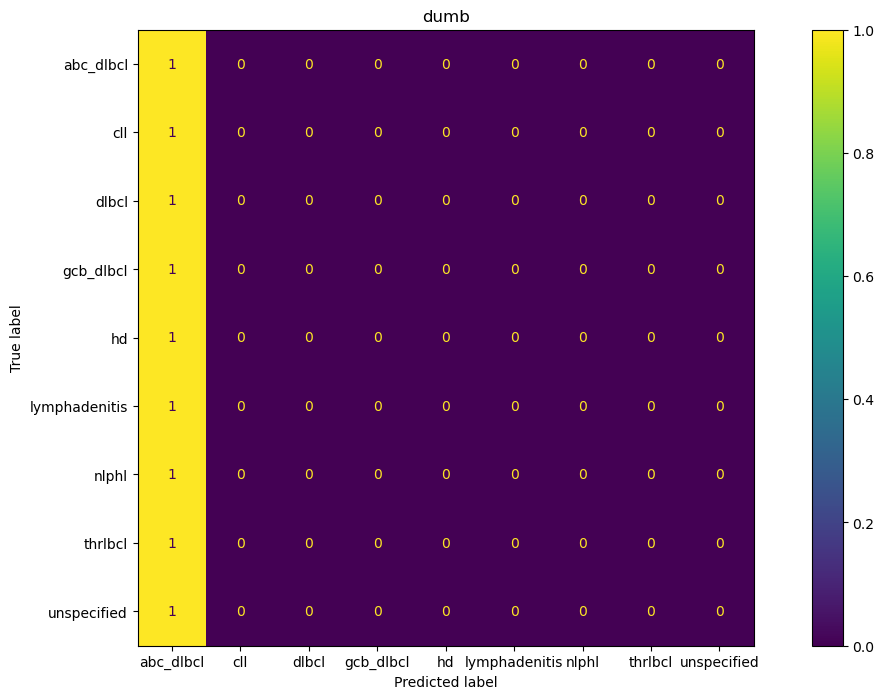

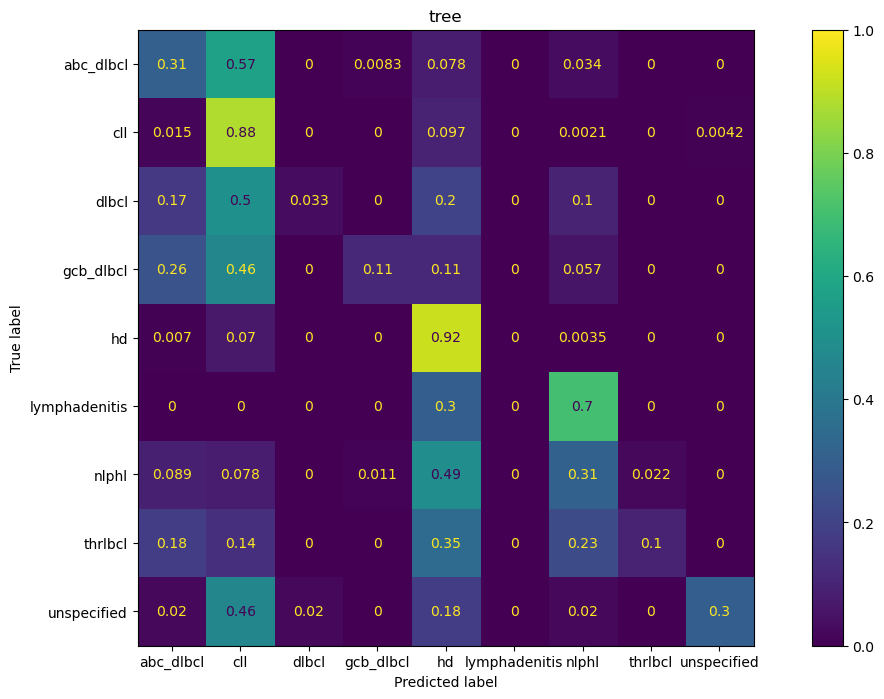

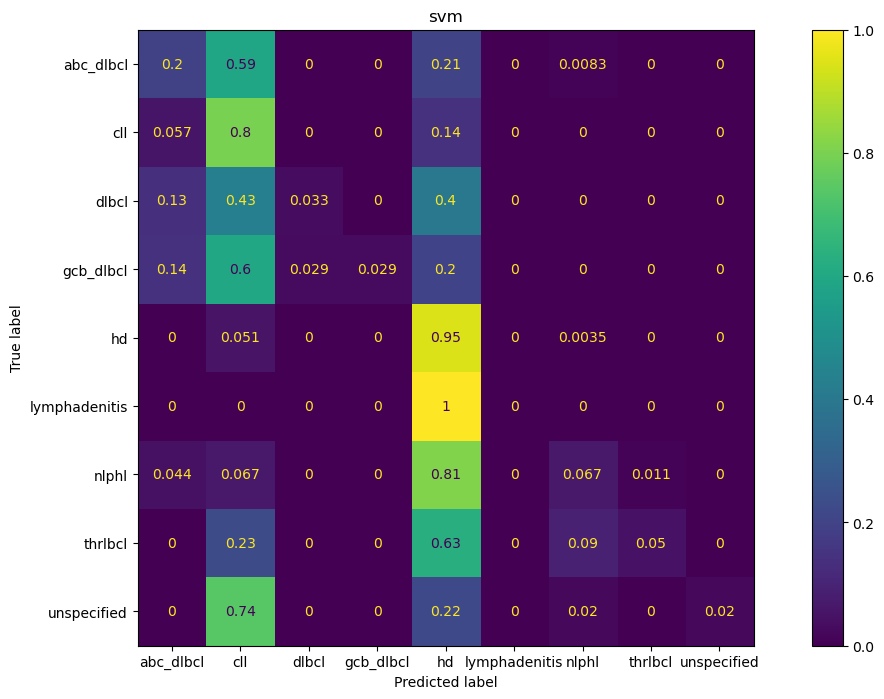

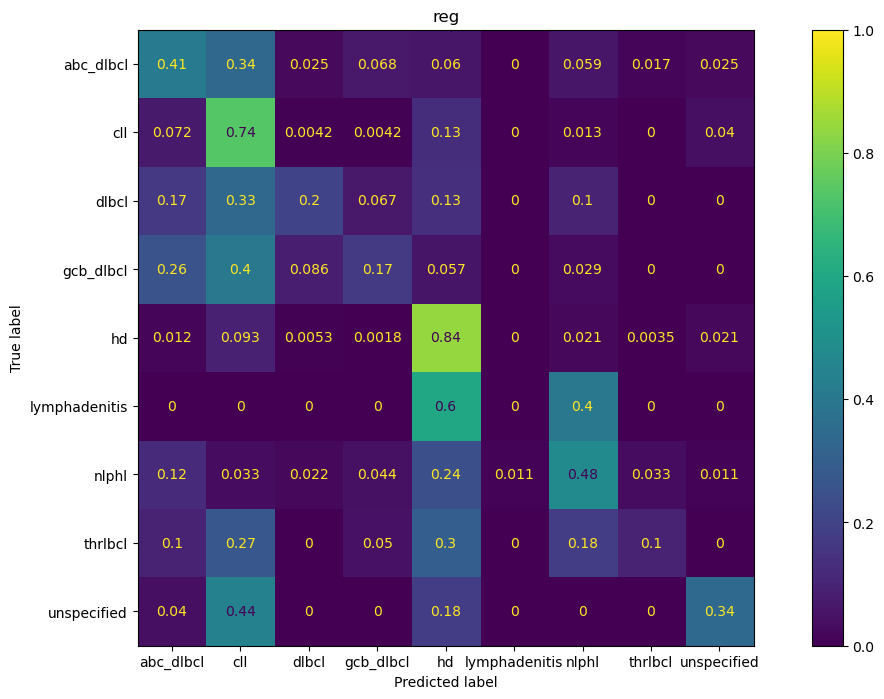

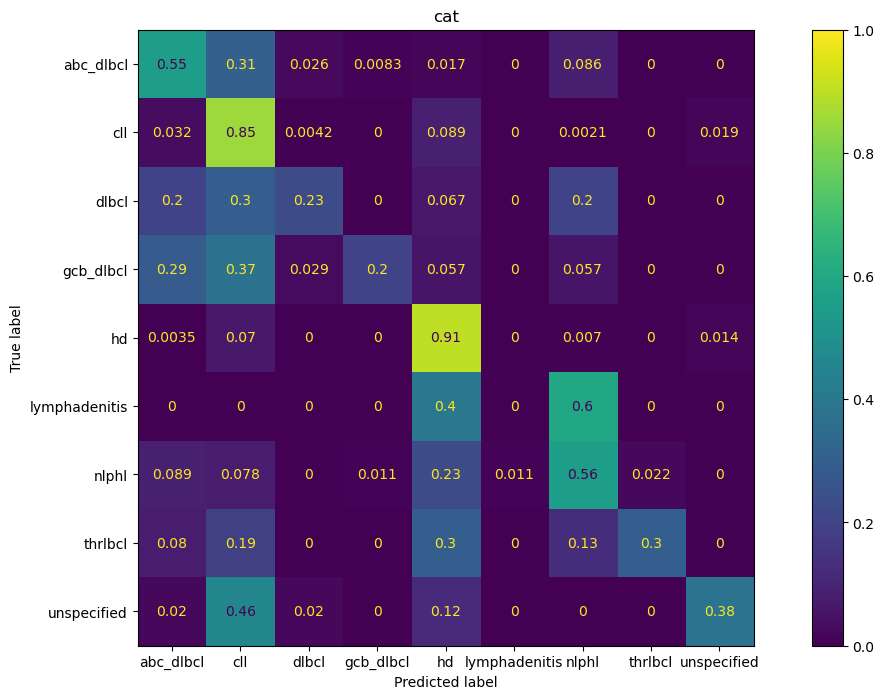

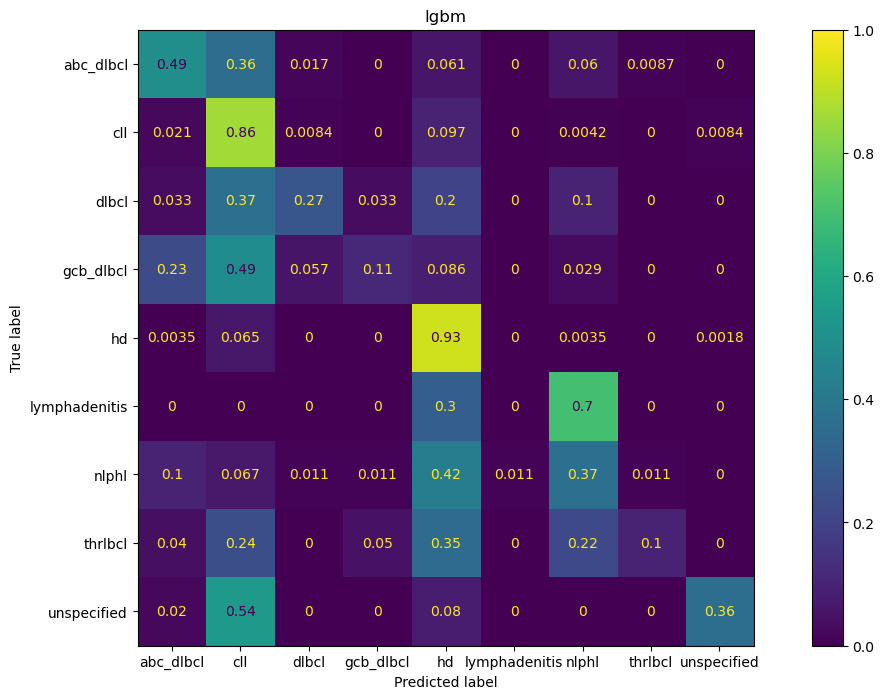

In [240]:
for key in fold_predictions.keys():
    cms = []
    for i, y_pred in enumerate(tqdm(fold_predictions[key])):
        cm = confusion_matrix(y_test_folds[i], y_pred, normalize="true") # normalize over true values
        cms.append(cm)
    cms = np.asarray(cms)
    
    fig, ax = plt.subplots(figsize = (15,8))
    disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(cms,axis=0),display_labels=labels,)
    ax.set_title(key)
    disp.plot(ax=ax)
    disp.ax_.get_images()[0].set_clim(0, 1)

## Feature Importance

(3104,)
(3104,)
(3104,)


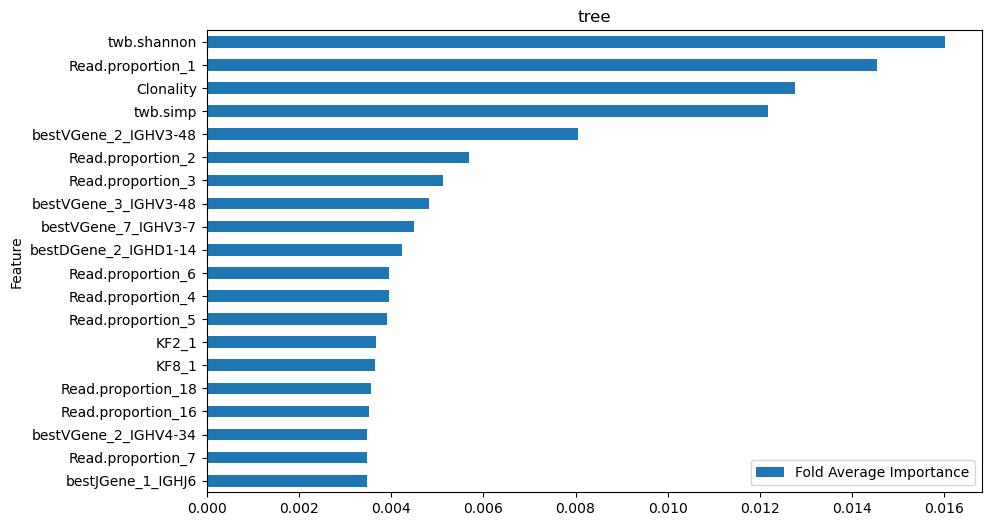

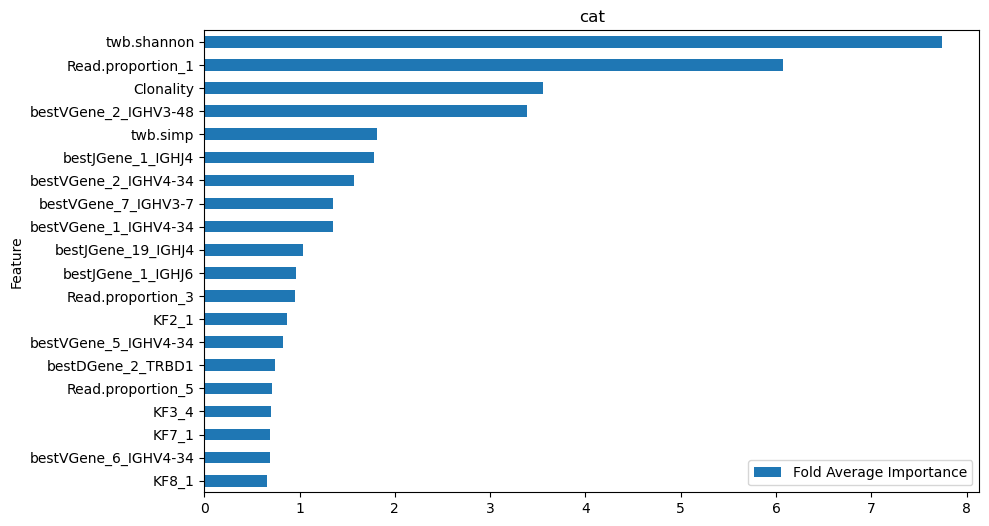

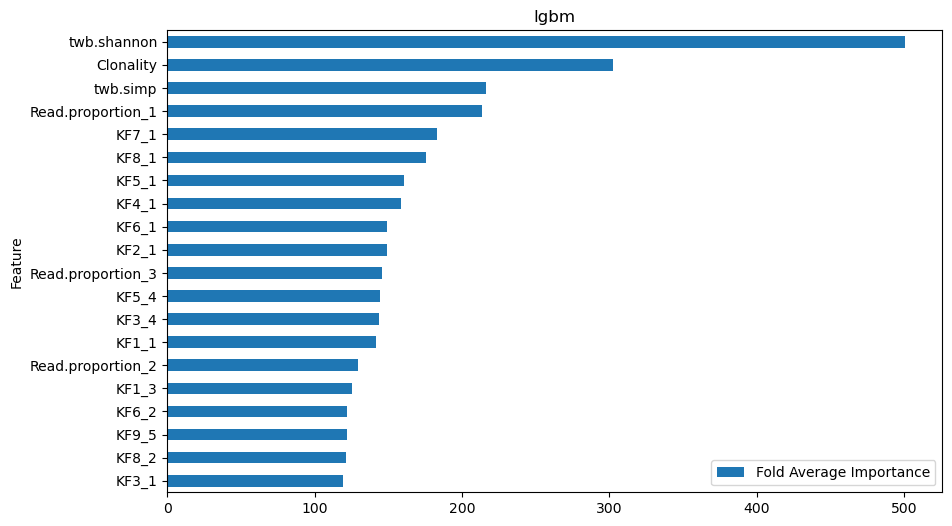

In [241]:
for key in ["tree", "cat", "lgbm"]:
    mean_coef = np.mean(np.asarray(coefficients[key]), axis=0)
    print(mean_coef.shape)
    palette = sns.color_palette(palette='Blues')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': mean_coef})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.iloc[-20:].plot(x='Feature', y='Importance', kind='barh', ax=ax, label = "Fold Average Importance")
    
    #for i, cof in enumerate(coefficients[key]):
    #    feature_importance_i = pd.DataFrame({'Feature': X_train.columns, 'Importance': cof})
    #    feature_importance_i = feature_importance_i.sort_values('Importance', ascending=True)
    #    feature_importance_i.iloc[-20:].plot(x='Feature', y='Importance', kind='barh', ax=ax, color =palette[i], alpha=0.4, label="", legend=False)
    ax.set_title(key)


# ANN

In [268]:
df.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

In [55]:
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/labadmin/Projects/immusign/utils.py'>

In [295]:
from sklearn.model_selection import train_test_split

In [ ]:
labels = ['abc_dlbcl', 'cll', 'dlbcl', 'gcb_dlbcl', 'hd', 'lymphadenitis', 'nlphl', 'thrlbcl', 'unspecified']

In [124]:
lymphoma_specification_dict = {}
for i, label in enumerate(labels):
    one_hot_vec = np.zeros(len(labels)) 
    one_hot_vec[i] = 1
    lymphoma_specification_dict[label] = one_hot_vec

In [92]:
df_top_n.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

In [320]:
X = df_top_n["CDR3.nucleotide.sequence"].apply(utils.encode_nucleotides)
Y = df_top_n["lymphoma_specification"].apply(lambda x: np.asarray(lymphoma_specification_dict[x]))

In [321]:
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, random_state=42
)

X_train_lens = X_train.apply(len)
X_valid_lens = X_valid.apply(len)

In [387]:
lymphoma_fold_dict,  train_fold_patients, test_fold_patients = utils.grouped_patientwise_k_folds(df_top_n, "lymphoma_specification", "clones.txt.name")

In [391]:
X_train_folds = []
y_train_folds = []
X_test_folds = []
y_test_folds = []

for i, train_fold in enumerate(tqdm(train_fold_patients)):
    test_fold = test_fold_patients[i]
    X_test = df_top_n[df_top_n["clones.txt.name"].isin(test_fold)]
    y_test = np.asarray(X_test["lymphoma_specification"])

    X_train = df_top_n[df_top_n["clones.txt.name"].isin(train_fold)]
    y_train = np.asarray(X_train["lymphoma_specification"])

    X_train_folds.append(X_train)
    X_test_folds.append(X_test)

    y_train_folds.append(y_train)
    y_test_folds.append(y_test)

  0%|          | 0/5 [00:00<?, ?it/s]

In [394]:
X_train = X_train_folds[0]["CDR3.nucleotide.sequence"].apply(utils.encode_nucleotides)
Y_train = X_train_folds[0]["lymphoma_specification"].apply(lambda x: np.asarray(lymphoma_specification_dict[x]))

X_valid = X_test_folds[0]["CDR3.nucleotide.sequence"].apply(utils.encode_nucleotides)
Y_valid = X_test_folds[0]["lymphoma_specification"].apply(lambda x: np.asarray(lymphoma_specification_dict[x]))

In [395]:
X_train_lens = X_train.apply(len)
X_valid_lens = X_valid.apply(len)

In [396]:
length_with_index_dict = {}
lengths = np.asarray(X_train.apply(len))
for i in np.sort(np.unique(lengths)):
    length_with_index_dict[i] = np.where(lengths == i)[0]

In [397]:
torch.manual_seed(SEED)

In [398]:
INPUT_DIM = 4
NUM_HIDDEN_NODES = 128
NUM_OUTPUT_NODES = 9
NUM_LAYERS = 2
DROPOUT = 0.5

In [399]:
importlib.reload(model_zoo)

<module 'model_zoo' from '/Users/labadmin/Projects/immusign/model_zoo.py'>

In [325]:
import model_zoo

In [354]:
model = model_zoo.LSTMNet(INPUT_DIM, 
                 NUM_OUTPUT_NODES, 
                 lstm_layers=2,
                 lstm_units=128,
                 bidirectional=True,
                 dropout=0.5,
                 fc_layer=2,
                 fc_hidden_dim=256,
               )

In [406]:
model = model_zoo.NonLinearModel(input_channel=INPUT_DIM,
                 output_channel=NUM_OUTPUT_NODES,
                 hidden_units = 256,)

In [250]:
model = ResnetModel(input_channel=INPUT_DIM,output_channel=NUM_OUTPUT_NODES,hidden_layers=NUM_LAYERS,hidden_units=NUM_HIDDEN_NODES)

In [301]:
# per patient
#class_counts = df.groupby(["lymphoma_specification", "clones.txt.name"]).size().reset_index().groupby("lymphoma_specification").size().reset_index()
# per clone
class_counts = df.groupby(["lymphoma_specification"]).size()
total_samples = sum(class_counts.values)
class_weights = [total_samples / (class_counts[i] * len(class_counts)) for i in range(len(class_counts))]
class_weights = torch.tensor(class_weights)

In [407]:
device = torch.device("mps")
#device = torch.device("cpu")
import torch.optim as optim
model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.BCELoss()

In [408]:
model.train()

NonLinearModel(
  (activation_function): LeakyReLU(negative_slope=0.01)
  (non_linear): Linear(in_features=4, out_features=256, bias=True)
  (linear): Linear(in_features=256, out_features=9, bias=True)
)

In [410]:
BATCH_SIZE =16
N_EPOCHS = 100

In [411]:
epoch_loss = []
epoch_acc = []
for ii in tqdm(range(N_EPOCHS), desc ='Training...',position=0,leave=True):
    average_epoch_loss = []
    average_epoch_metric = []
    average_epoch_acc = []
    
    running_loss = 0.0
    epoch = create_epoch_with_same_size_batching(length_with_index_dict, BATCH_SIZE , shuffle=True)

    for jj, idxs in enumerate(tqdm(epoch,desc = "Batch...",position=1, leave=False)): #enumerate(epoch):
        model.train()
        # index by indices in batch

        batch_input_jj = X_train.iloc[idxs]
        
        batch_input_jj_lens = torch.from_numpy(X_train_lens.iloc[idxs].values)#.to(device)
        
        batch_input = pad_batch_online(batch_input_jj_lens, batch_input_jj, style="zero")
        batch_input = torch.from_numpy(batch_input).to(device, dtype=torch.float32)

       
        Y_hat = model(batch_input, batch_input_jj_lens)

        batch_output_jj = torch.from_numpy(np.stack(Y_train.iloc[idxs].values)).to(device, dtype=torch.float32)


        optimizer.zero_grad() # set gradients to zero before performing backprop
        loss = criterion(Y_hat.squeeze(), batch_output_jj.to(torch.float32))
        average_epoch_loss += [loss.item()]
        
        #f1score = metric(Y_hat, batch_output_jj)
        #average_epoch_metric += [f1score.item()]
        
        running_loss += loss.item()
        loss.backward()  # compute dloss/dx and accumulated into x.grad
        optimizer.step()  # compute x += -learning_rate * x.grad

        model.eval()
        Y_hat = model(batch_input, batch_input_jj_lens)
        Y_hat = torch.nn.functional.softmax(Y_hat, dim=1)
        
        pred_labels = np.argmax(Y_hat.detach().cpu().numpy(),axis=1)
        true_labels = np.argmax(batch_output_jj.detach().cpu().numpy(), axis=1)
        
        acc = np.mean(pred_labels == true_labels)
        average_epoch_acc += [acc]
    
    epoch_loss += [np.mean(average_epoch_loss)]
    epoch_acc += [np.mean(average_epoch_acc)]
    #print("Avg Training Loss: " + str(np.mean(average_epoch_loss)) + "\n" +
    #      #"Avg Training Score: " + str(np.mean(average_epoch_metric)) + "\n" +
    #      "Running Training Loss: " + str(float(running_loss)))
    #time.sleep(0.1)
    

Training...:   0%|          | 0/100 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

Batch...:   0%|          | 0/613 [00:00<?, ?it/s]

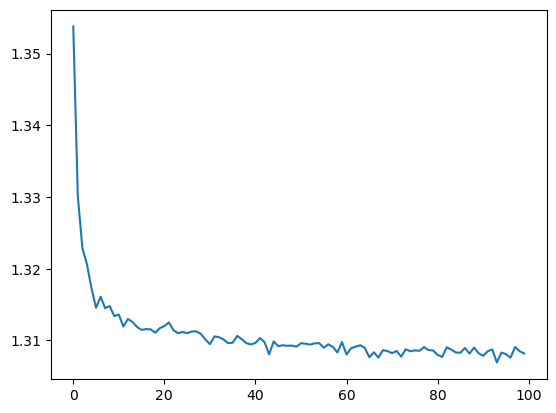

In [412]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_loss )), epoch_loss)

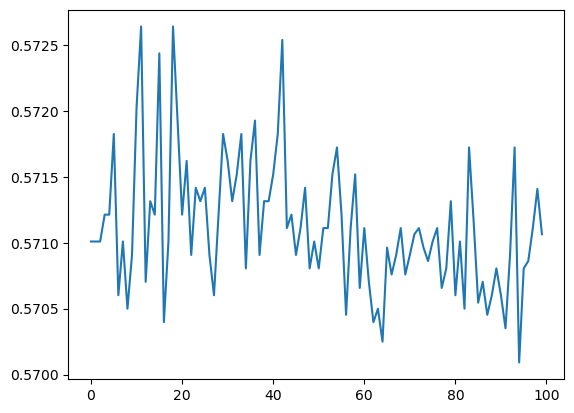

In [413]:
fig, ax = plt.subplots()
ax.plot(range(len(epoch_acc)), epoch_acc)

In [414]:
model.eval()
true_labels = []
pred_labels = []

for i,x in enumerate(tqdm(X_valid)):
    x_lens = torch.Tensor([X_valid_lens.iloc[i]])
    x = torch.from_numpy(np.expand_dims(X_valid.iloc[i],axis=0)).to(torch.float32).to(device)
    output = model(x, x_lens)
    Y_hat = torch.nn.functional.softmax(output, dim=1)
    
    batch_output_jj = torch.from_numpy(Y_valid.iloc[i]).to(device,dtype=torch.float32)
           
    pred_labels += [np.argmax(Y_hat.detach().cpu().numpy(),axis=1)]
    true_labels += [np.argmax(batch_output_jj.detach().cpu().numpy())]

  0%|          | 0/2412 [00:00<?, ?it/s]

In [415]:
print(classification_report(true_labels, pred_labels, target_names=np.asarray(target_names),output_dict=False))

               precision    recall  f1-score   support

    abc_dlbcl       0.00      0.00      0.00        83
          cll       1.00      0.00      0.00       543
        dlbcl       0.00      0.00      0.00        26
    gcb_dlbcl       0.00      0.00      0.00        60
           hd       0.58      1.00      0.73      1400
lymphadenitis       0.00      0.00      0.00        20
        nlphl       0.00      0.00      0.00       180
      thrlbcl       0.00      0.00      0.00        40
  unspecified       0.00      0.00      0.00        60

     accuracy                           0.58      2412
    macro avg       0.18      0.11      0.08      2412
 weighted avg       0.56      0.58      0.43      2412



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# Stacked and padded input to SVM

input = pad_batch_online(X_train_lens, X_train, style="zero").reshape((X_train.shape[0],-1))

In [184]:
input_valid = pad_batch_online(X_valid_lens, X_valid, style="zero").reshape((X_valid.shape[0],-1))

In [185]:
model = SVC(kernel='rbf')
model.fit(input, Y_train.apply(lambda x: np.where(x==1)[0][0]))

SVC()

In [186]:
Y_valid.apply(lambda x: np.where(x==1)[0][0]).unique()

array([2, 0, 3, 1, 5])

In [187]:
Y_pred = model.predict(input_valid)

In [190]:
np.unique(Y_pred)

array([0, 1, 2, 3, 5])

In [191]:
print(classification_report(Y_valid.apply(lambda x: np.where(x==1)[0][0]), Y_pred, ))

              precision    recall  f1-score   support

           0       0.56      0.87      0.68       133
           1       0.84      0.28      0.42        57
           2       0.63      0.65      0.64       113
           3       1.00      0.19      0.32        31
           5       1.00      0.07      0.13        14

    accuracy                           0.61       348
   macro avg       0.81      0.41      0.44       348
weighted avg       0.69      0.61      0.57       348



# Important Clones Analysis

In [2]:
df = pd.read_pickle("immusign/immusign_not_normalized_with_out_of_frame_merged_raw_data_cleaned.pkl")

In [3]:
important_clones = pd.read_json("immusign/important_clones.json")

In [4]:
df_clones = pd.DataFrame()
files = []
clones = []
type = []
clone_fraction = []
for column in important_clones.columns:
    files.append(column)
    clones.append(important_clones[column]["important_clones"])
    type.append(important_clones[column]["type"])
    clone_fraction.append(important_clones[column]["clone_fractions"])

df_clones["file"] = files
df_clones["clones"] = clones
df_clones["type"] = type
df_clones["clone_fraction"] = clone_fraction

In [5]:
df_clones

,file,clones,type,clone_fraction
0,LisaS-hs-FR3-NLPHL-12-ED_S118.clones.txt,"[144, 147, 159, 162]",NLPHL,0.015793
1,LisaS-hs-FR3-NLPHL-38-Rez_S117.clones.txt,"[698, 719, 866]",NLPHL,0.000416
2,LisaS-hs-FR3-DLBCL29_S95.clones.txt,[0],DLBCL,0.883132
3,LisaS-hs-FR3-DLBCL18_S84.clones.txt,[0],DLBCL,0.948365
4,CW-hs-IGHFR3-GCB-DLBCL-K4-028-tm_S51.clones.txt,[0],DLBCL,0.995391
5,LisaS-hs-FR3-NLPHL-18-ED_S259.clones.txt,[3],NLPHL,0.030426
6,LisaS-hs-FR3-NLPHL-10-Rez_S114.clones.txt,[29],DLBCL,0.106383
7,LisaS-hs-FR3-NLPHL-22-ED_S172.clones.txt,"[130, 402, 824]",NLPHL,0.065063
8,LisaS-hs-FR3-DLBCL03_S35.clones.txt,[0],DLBCL,0.978579
9,LisaS-hs-FR3-DLBCL05_S37.clones.txt,"[29, 87, 618]",DLBCL,0.371608


In [6]:
important_clones_in_full_data = pd.DataFrame()
missing_files_and_clones = []

for i, row in df_clones.iterrows():
    file = row.file
    for clone in row.clones:
        df_sub = df[(df["clones.txt.name"] == file) & (df["cloneId"] == clone)]
        if len(df_sub) == 0:
            missing_files_and_clones.append([file,clone])
        important_clones_in_full_data = pd.concat([important_clones_in_full_data,df_sub])

In [7]:
missing_files_and_clones

[]

In [9]:
df.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

Creating legend with loc="best" can be slow with large amounts of data.


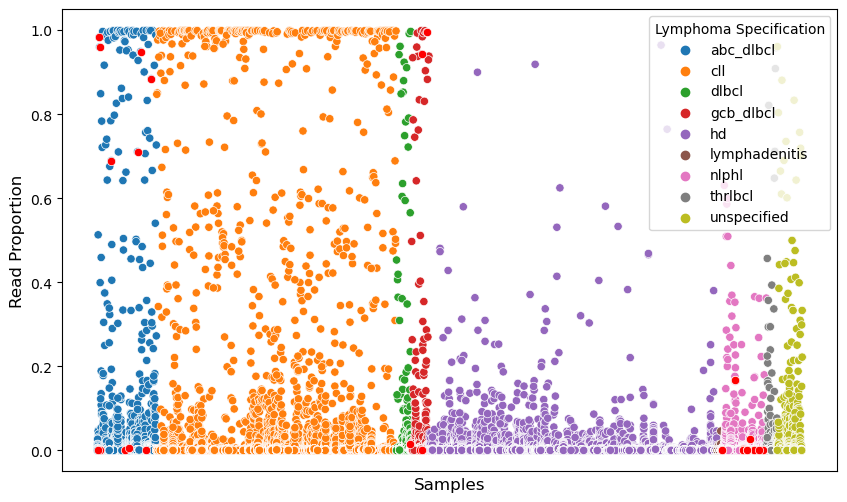

In [330]:
fig, ax = plt.subplots(figsize=(10, 6))
df.sort_values(by="lymphoma_specification", inplace = True)
sns.scatterplot(x='clones.txt.name', y='Read.proportion', hue='lymphoma_specification', data=df)
sns.scatterplot(x='clones.txt.name', y='Read.proportion', data=important_clones_in_full_data, color = "red") 
ax.set_xticks([])
ax.set_ylabel("Read Proportion", size=12)
ax.set_xlabel("Samples", size=12)
ax.legend(title='Lymphoma Specification')
plt.show()

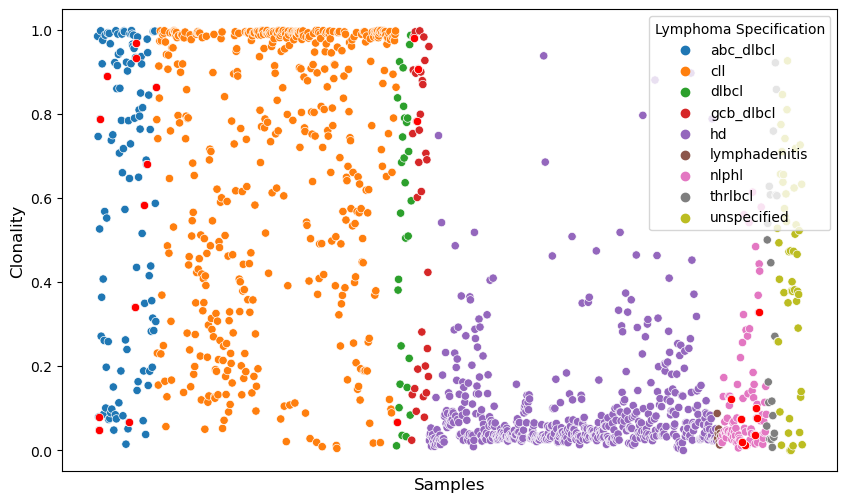

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
df_sample = df.groupby('clones.txt.name').first()
df_sample.sort_values(by="lymphoma_specification", inplace = True)
sns.scatterplot(x='clones.txt.name', y='Clonality', hue='lymphoma_specification', data=df_sample)
sns.scatterplot(x='clones.txt.name', y='Clonality', data=important_clones_in_full_data, color = "red") 
ax.set_xticks([])
ax.set_ylabel("Clonality", size=12)
ax.set_xlabel("Samples", size=12)
ax.legend(title='Lymphoma Specification')
plt.show()

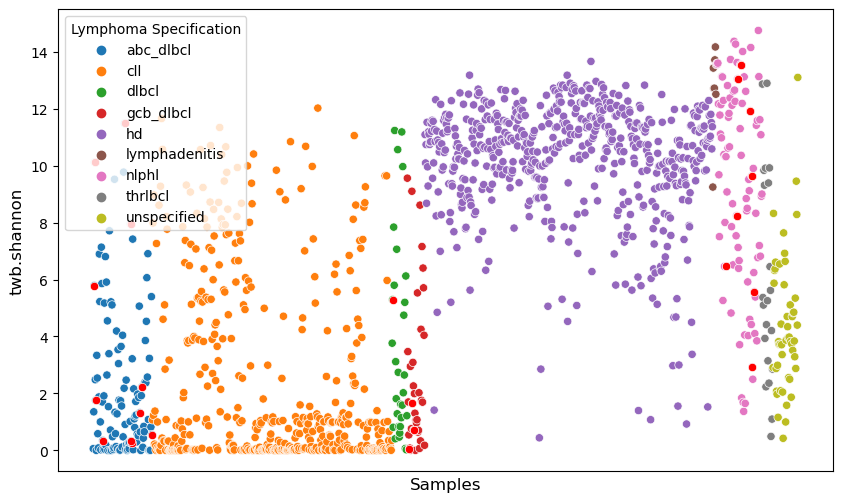

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
df_sample = df.groupby('clones.txt.name').first()
df_sample.sort_values(by="lymphoma_specification", inplace = True)
sns.scatterplot(x='clones.txt.name', y='twb.shannon', hue='lymphoma_specification', data=df_sample)
sns.scatterplot(x='clones.txt.name', y='twb.shannon', data=important_clones_in_full_data, color = "red") 
ax.set_xticks([])
ax.set_ylabel("twb.shannon", size=12)
ax.set_xlabel("Samples", size=12)
ax.legend(title='Lymphoma Specification')
plt.show()

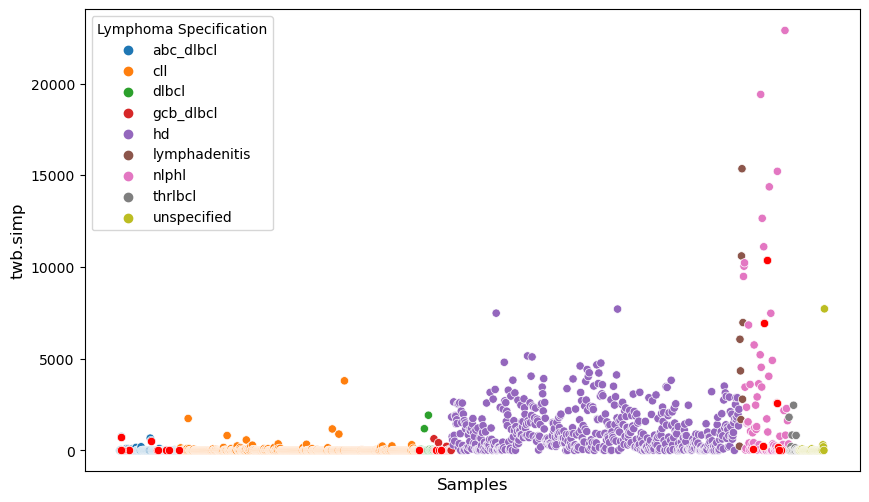

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
df_sample = df.groupby('clones.txt.name').first()
df_sample.sort_values(by="lymphoma_specification", inplace = True)
sns.scatterplot(x='clones.txt.name', y='twb.simp', hue='lymphoma_specification', data=df_sample)
sns.scatterplot(x='clones.txt.name', y='twb.simp', data=important_clones_in_full_data, color = "red") 
ax.set_xticks([])
ax.set_ylabel("twb.simp", size=12)
ax.set_xlabel("Samples", size=12)
ax.legend(title='Lymphoma Specification')
plt.show()

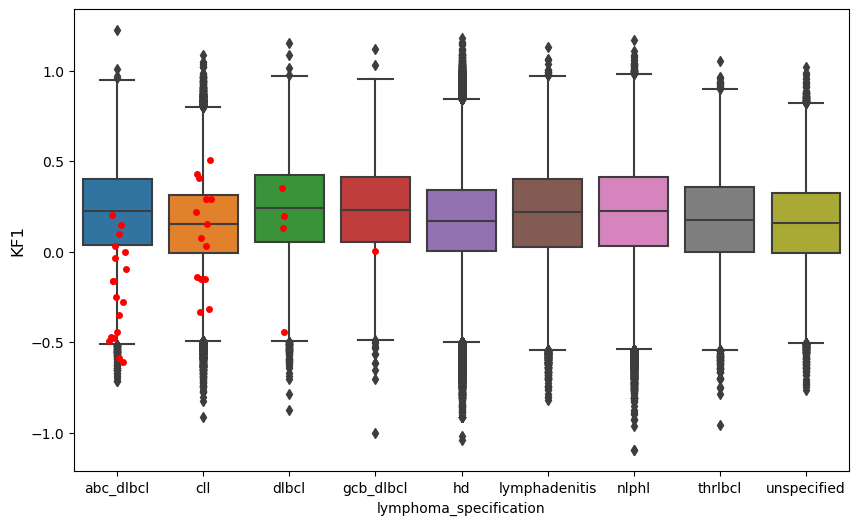

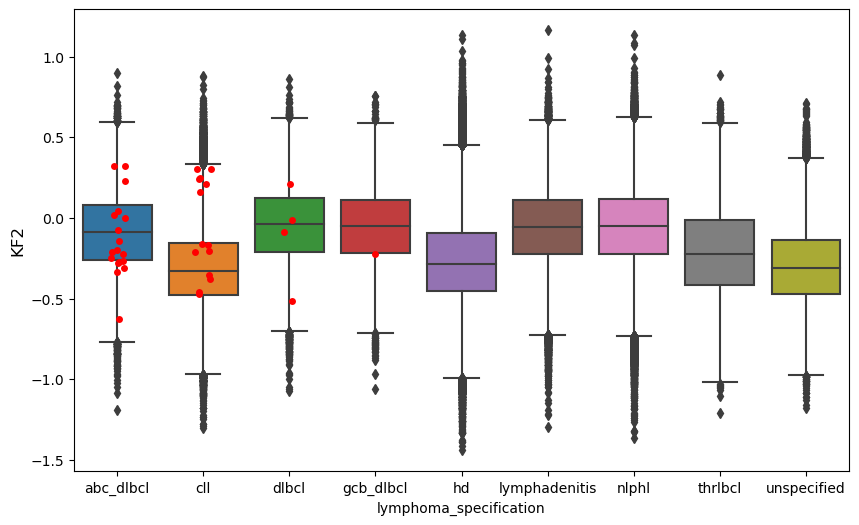

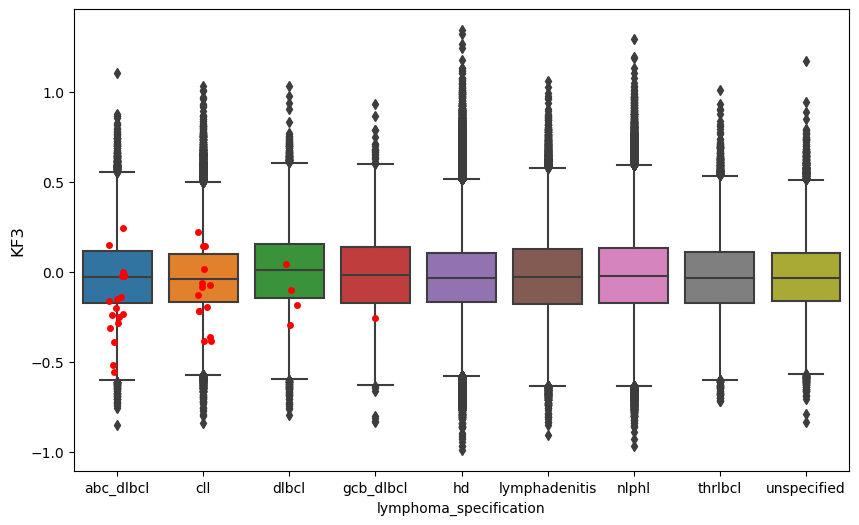

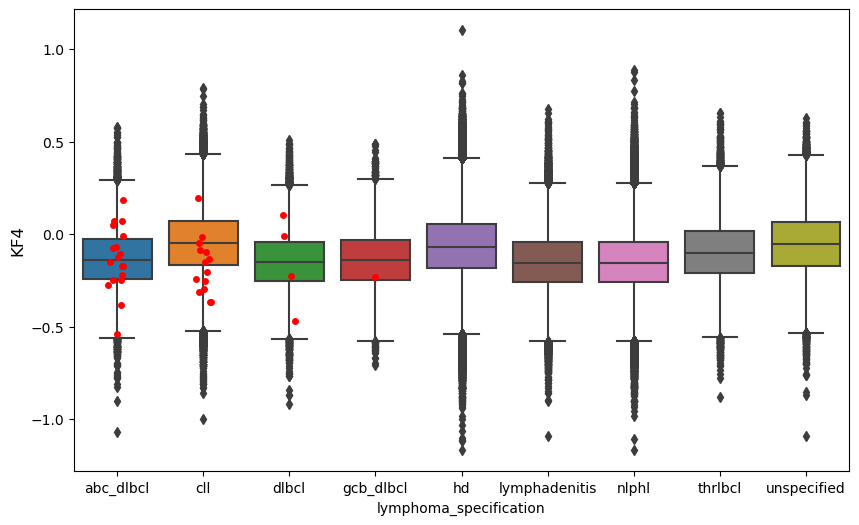

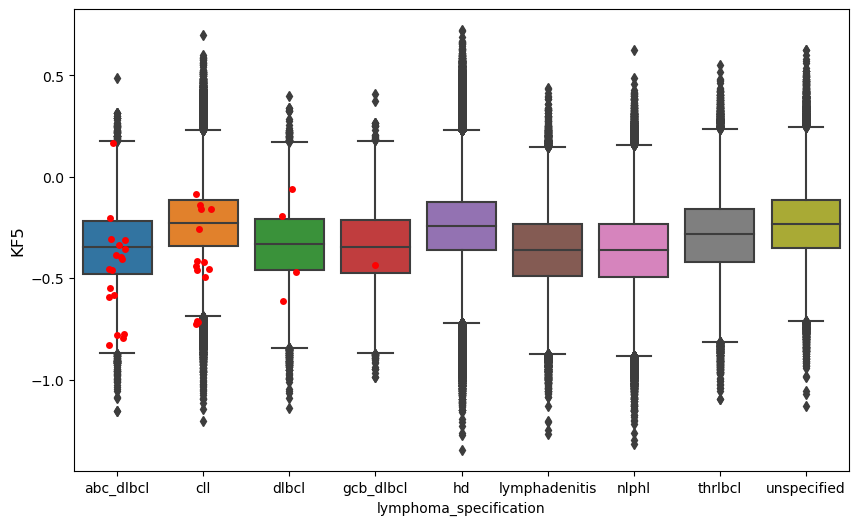

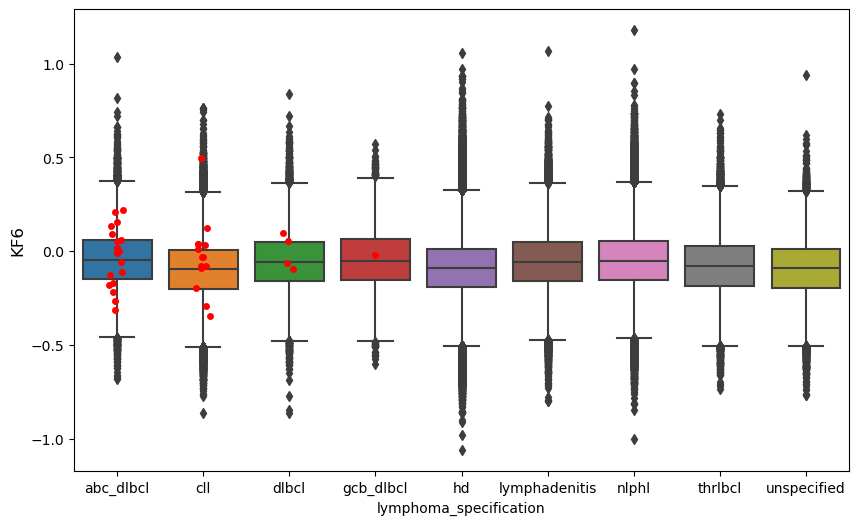

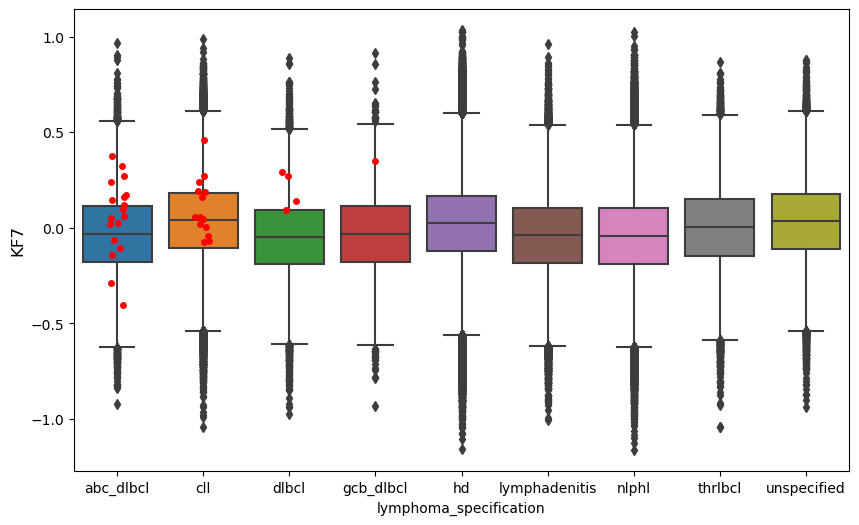

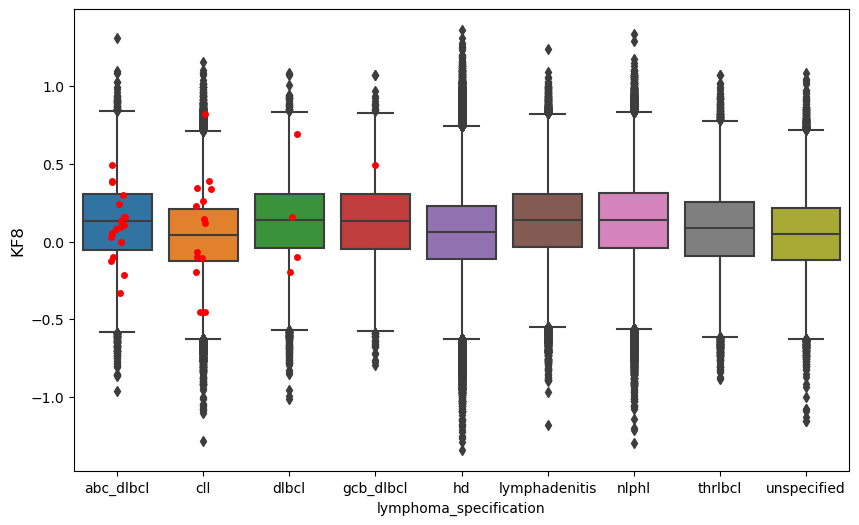

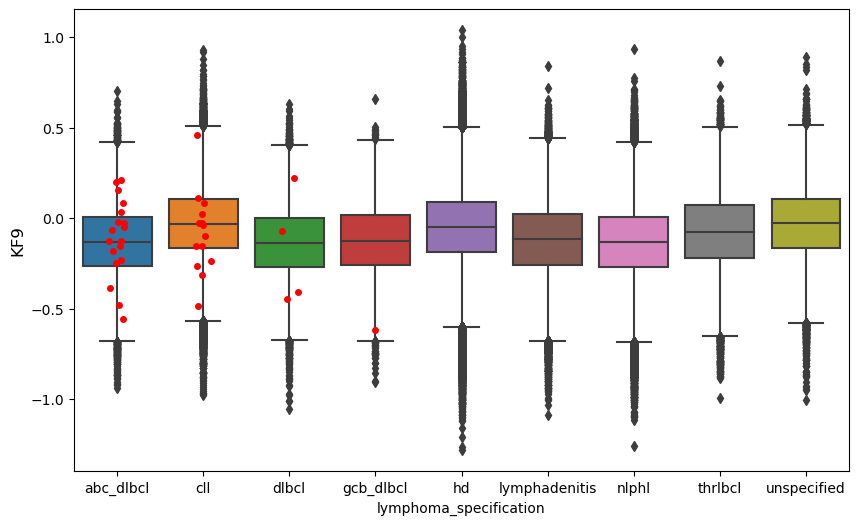

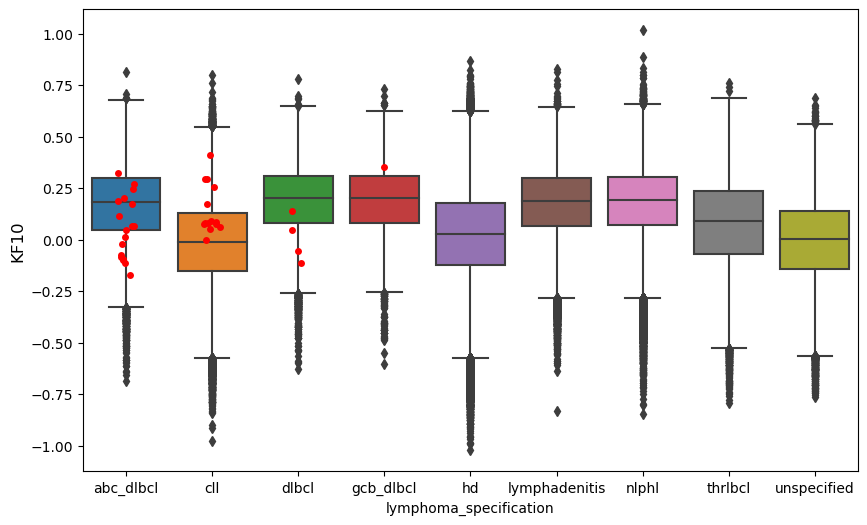

In [15]:
df.sort_values(by="lymphoma_specification", inplace = True)
for i in range(10):
    i = i+1 
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x='lymphoma_specification', y='KF%d' % i, data=df)
    sns.stripplot(x = "lymphoma_specification",
               y='KF%d' % i,
              data = important_clones_in_full_data, color = "red")
    ax.set_ylabel("KF%d" % i, size=12)
    #ax.legend(title='Lymphoma Specification')
    plt.show()

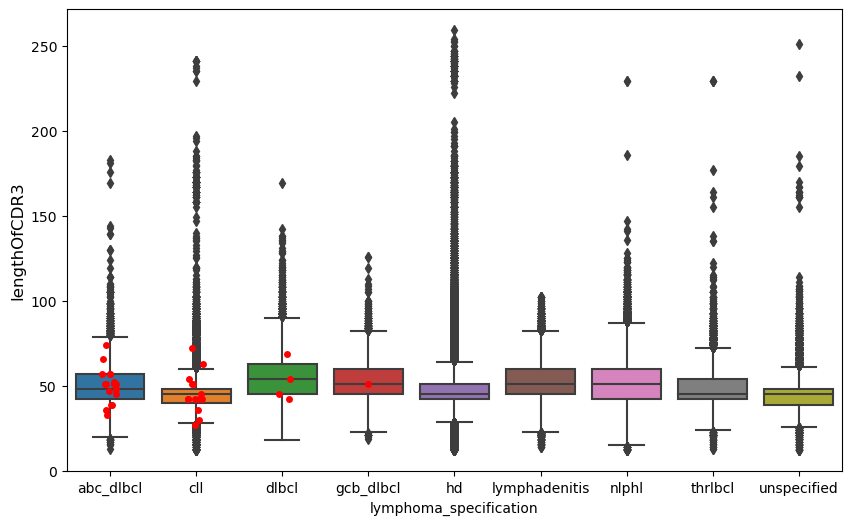

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='lymphoma_specification', y='lengthOfCDR3', data=df)
sns.stripplot(x = "lymphoma_specification",
           y='lengthOfCDR3',
          data = important_clones_in_full_data, color = "red")
ax.set_ylabel("lengthOfCDR3", size=12)
#ax.legend(title='Lymphoma Specification')
plt.show()

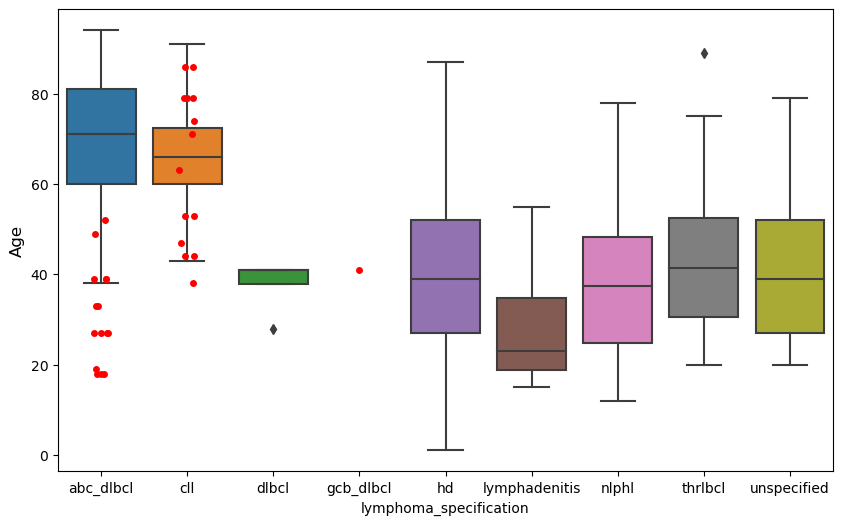

In [17]:
df_sample.sort_values(by="lymphoma_specification", inplace = True)
i = i+1 
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='lymphoma_specification', y='age', data=df_sample)

sns.stripplot(x = "lymphoma_specification",
           y='age' ,
          data = important_clones_in_full_data, color = "red")
ax.set_ylabel("Age", size=12)
#ax.legend(title='Lymphoma Specification')
plt.show()

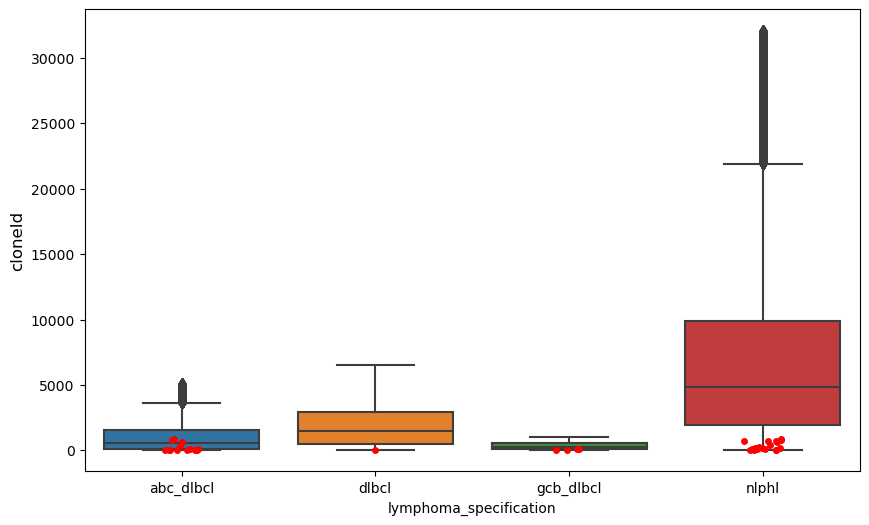

In [21]:
df.sort_values(by="lymphoma_specification", inplace = True)
df_interesting_lymphom = df[df["lymphoma_specification"].isin(important_clones_in_full_data.lymphoma_specification.unique())]
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='lymphoma_specification', y='cloneId', data=df_interesting_lymphom)
sns.stripplot(x = "lymphoma_specification",
           y='cloneId' ,
          data = important_clones_in_full_data, color = "red")
ax.set_ylabel("cloneId", size=12)
#ax.legend(title='Lymphoma Specification')
plt.show()

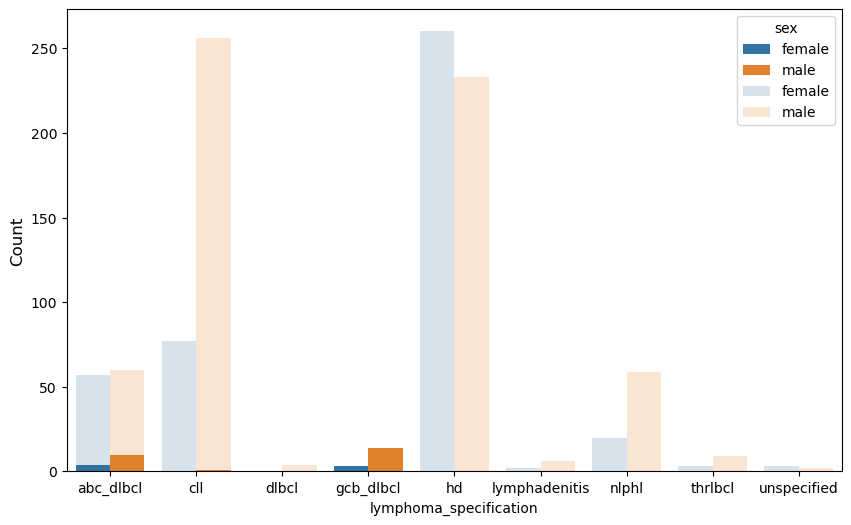

In [22]:
df_sample.sort_values(by=["lymphoma_specification", "sex"], inplace = True)
important_clones_in_full_data.sort_values(by=["lymphoma_specification", "sex"], inplace = True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='lymphoma_specification', hue='sex', data=important_clones_in_full_data, palette=["C0", "C1"])
sns.countplot(x='lymphoma_specification', hue='sex', data=df_sample, alpha = 0.2,palette=["C0", "C1"])
ax.set_ylabel("Count", size=12)

#ax.legend(title='Lymphoma Specification')
plt.show()

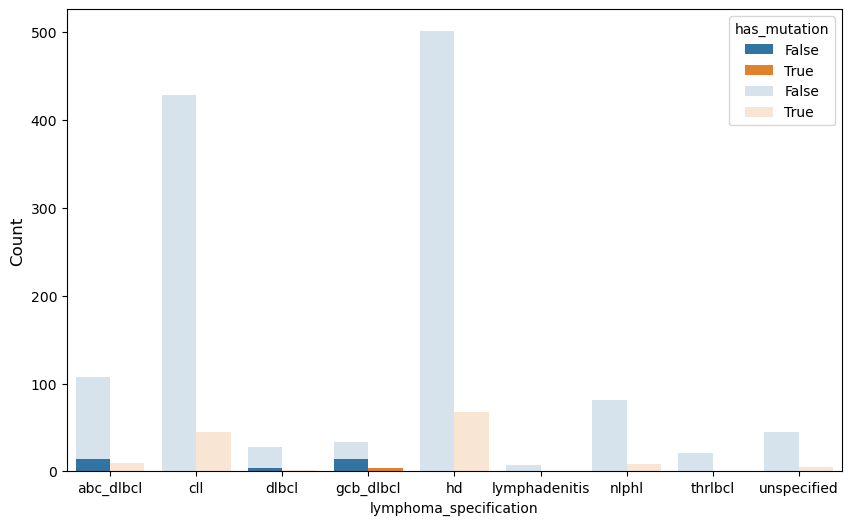

In [23]:
df_sample.sort_values(by="lymphoma_specification", inplace = True)
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='lymphoma_specification', hue='has_mutation', data=important_clones_in_full_data)
sns.countplot(x='lymphoma_specification', hue='has_mutation', data=df_sample, alpha = 0.2)
ax.set_ylabel("Count", size=12)

#ax.legend(title='Lymphoma Specification')
plt.show()

In [24]:
df.columns

Index(['Read.count', 'Read.proportion', 'CDR3.nucleotide.sequence',
       'CDR3.amino.acid.sequence', 'V.gene', 'J.gene', 'D.gene', 'V.end',
       'J.start', 'D5.end', 'D3.end', 'VD.insertions', 'DJ.insertions',
       'Total.insertions', 'sample', 'cloneId', 'clones.txt.name',
       '#Nucleotide clones', '#Aminoacid clonotypes', '%Aminoacid clonotypes',
       '#In-frames', '%In-frames', '#Out-of-frames', '%Out-of-frames',
       'Sum.reads', 'Min.reads', '1st Qu.reads', 'Median.reads', 'Mean.reads',
       '3rd Qu.reads', 'Max.reads', 'Clonality', 'twb.shannon', 'twb.simp',
       'pcr_target_locus', 'organism', 'template', 'tissue', 'lymphoma_type',
       'lymphoma_specification', 'subject_id', 'sex', 'dosc', 'age', 'dob',
       'cloneCount', 'cloneFraction', 'aaSeqCDR3', 'bestVGene', 'bestDGene',
       'bestJGene', 'vBestIdentityPercent', 'lengthOfCDR3', 'targetSequences',
       'allVGenes', 'allDGenes', 'allJGenes', 'allVHits', 'allDHits',
       'allJHits', 'allVAlignments

In [31]:
bestV_per_lymphom_frequency = df.groupby(["lymphoma_specification","bestVGene"]).size().reset_index().sort_values(by = ["lymphoma_specification",0])

In [40]:
lymphom_freq = df.groupby("lymphoma_specification").size().reset_index()

In [34]:
top3V = bestV_per_lymphom_frequency.groupby("lymphoma_specification").tail(3)

In [35]:
top3V

,lymphoma_specification,bestVGene,0
35,abc_dlbcl,IGHV3-48,1953
61,abc_dlbcl,IGHV4-59,2210
56,abc_dlbcl,IGHV4-34,4550
186,cll,TRBV20-1,12529
184,cll,TRBV19,14310
211,cll,TRBV6-5,14458
254,dlbcl,IGHV3-23,2475
266,dlbcl,IGHV3-48,3033
288,dlbcl,IGHV4-34,3914
352,gcb_dlbcl,IGHV4-59,988


In [75]:
groups = []
top3_dict = {
    "top1V": [],
    "top2V": [],
    "top3V": []
}

Vgen_dict = {
    "top1V": [],
    "top2V": [],
    "top3V": []
}

for label in top3V.lymphoma_specification.unique():
    df_i= top3V[top3V.lymphoma_specification == label]
    freq = lymphom_freq[lymphom_freq.lymphoma_specification == label][0].iloc[0]
    top3_dict["top3V"].append(df_i.iloc[0][0]/freq)
    top3_dict["top2V"].append(df_i.iloc[1][0]/freq)
    top3_dict["top1V"].append(df_i.iloc[2][0]/freq)

    Vgen_dict["top3V"].append(df_i.iloc[0]["bestVGene"])
    Vgen_dict["top2V"].append(df_i.iloc[1]["bestVGene"])
    Vgen_dict["top1V"].append(df_i.iloc[2]["bestVGene"])
    
    groups.append(label)


In [76]:
color_dict = {}
for i, key in enumerate(top3V.bestVGene.unique()):
   color_dict[key] = "C%d" % i 

In [83]:
color_dict.keys()

dict_keys(['IGHV3-48', 'IGHV4-59', 'IGHV4-34', 'TRBV20-1', 'TRBV19', 'TRBV6-5', 'IGHV3-23', 'IGHV3-7', 'TRBV27', 'IGHV4-55'])

In [73]:
color_dict

{'IGHV3-48': 'C0',
 'IGHV4-59': 'C1',
 'IGHV4-34': 'C2',
 'TRBV20-1': 'C3',
 'TRBV19': 'C4',
 'TRBV6-5': 'C5',
 'IGHV3-23': 'C6',
 'IGHV3-7': 'C7',
 'TRBV27': 'C8',
 'IGHV4-55': 'C9'}

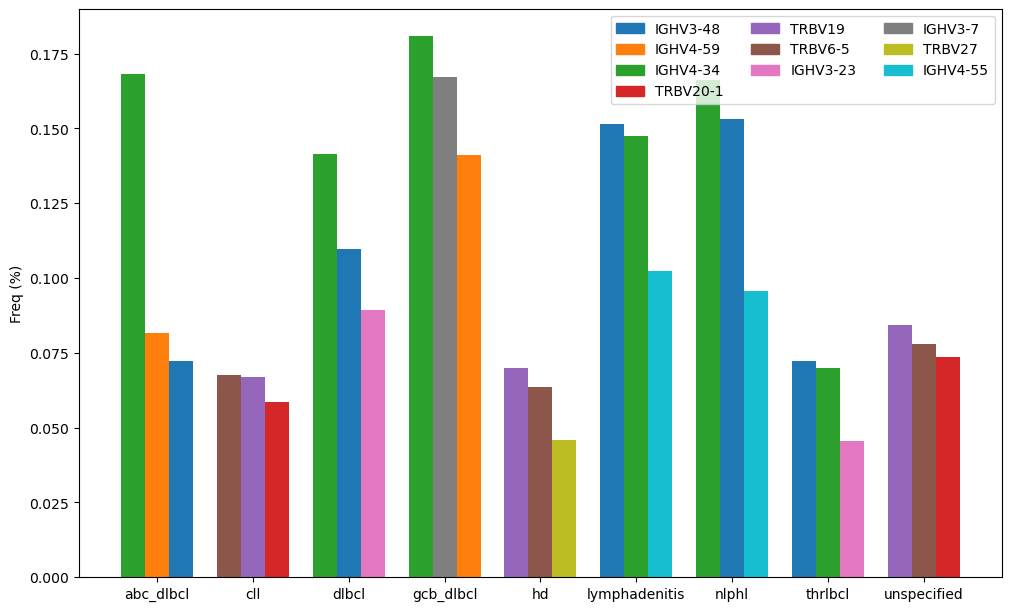

In [89]:
import matplotlib.patches as mpatches
x = np.arange(len(groups))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10, 6) )

for attribute, measurement in top3_dict.items():
    offset = width * multiplier
    colors = [color_dict[i] for i in Vgen_dict[attribute]]
    rects = ax.bar(x + offset, measurement, width, color=colors)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Freq (%)')
ax.set_title('')
ax.set_xticks(x + width, groups)

handles = []
for i in color_dict.keys():
    handles.append(mpatches.Patch(color=color_dict[i], label=i))
ax.legend(handles=handles, ncols=3)

plt.show()

In [ ]:
penguin_means = {
    'Bill Depth': (18.35, 18.43, 14.98),
    'Bill Length': (38.79, 48.83, 47.50),
    'Flipper Length': (189.95, 195.82, 217.19),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 250)

plt.show()

# Ideas
- Check V Genes
- Check cd3 levenshtein for subsets
- Phate plot

# Levenshtein CDR Nucleotide Sequence within group

In [18]:
import itertools
from Levenshtein import distance as lev

In [19]:
important_clones_in_full_data.lymphoma_specification.unique()
print(max(important_clones_in_full_data.cloneId.unique()))

910


In [10]:
np.sort(important_clones_in_full_data.cloneId.unique())

array([0, 2, 3, 15, 27, 29, 64, 76, 87, 98, 128, 130, 144, 147, 159, 162,
       169, 295, 351, 402, 618, 626, 698, 719, 731, 783, 824, 866, 910],
      dtype=object)

In [20]:
df_important_specification = df[(df["lymphoma_specification"].isin(important_clones_in_full_data.lymphoma_specification.unique())) & (df["cloneId"]<=402)]

In [21]:
len(df_important_specification)

51548

In [ ]:
pair_order_list = itertools.product(df_important_specification["CDR3.nucleotide.sequence"], repeat=2)
samples = len(df_important_specification["CDR3.nucleotide.sequence"])
lev_distances = np.zeros(shape=(samples,samples))

for i, pair in enumerate(tqdm(list(pair_order_list))):
    row = i//samples
    col = i%samples
    lev_distances[row,col] = lev(pair[0], pair[1])

  0%|          | 0/2657196304 [00:00<?, ?it/s]

In [25]:
lev_distances.shape

(44100, 44100)

In [29]:
from sklearn.cluster import HDBSCAN
cluster_labels = HDBSCAN(metric = "precomputed").fit_predict(lev_distances)

In [31]:
np.unique(cluster_labels)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [ ]:
important_points = []
for idx in list(important_clones_in_full_data.index):
    important_points.append(np.where(np.asarray(list(df_important_specification.index)) == idx)[0][0])

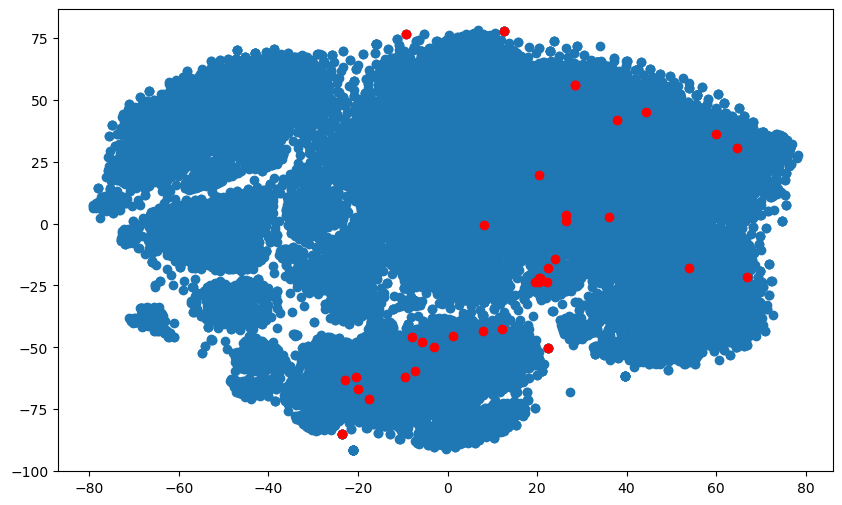

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X_embedded[:,0], X_embedded[:,1])
ax.scatter(X_embedded[important_points,0], X_embedded[important_points,1], color="red")
plt.show()

In [ ]:
import umap
X_embedded_umap = umap.UMAP(metric='precomputed').fit_transform(lev_distances)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X_embedded_umap[:,0], X_embedded_umap[:,1])
ax.scatter(X_embedded_umap[important_points,0], X_embedded_umap[important_points,1], color="red")
plt.show()